In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pprint
from IPython.display import clear_output

In [2]:
from google.colab import files
# files.download('example.txt') 


ModuleNotFoundError: No module named 'google'

# Initial system

In [3]:
def AA(t):
    res = np.array([[np.cos(t), np.sin(t)],
                    [-np.sin(t), np.cos(t)]])
    return np.array(res)

def BB(t):
    return np.array([[np.cos(t), 0],
                    [0, np.sin(t)]])
def uu(t):
    return np.array([[np.exp(np.sin(t)), np.exp(np.sin(t)) * (1 - np.cos(t) + np.sin(t))]]).T

def xx(t):
    return np.array([[np.exp(np.sin(t)) * (1 - np.cos(t) + np.sin(t)), np.exp(np.sin(t))]]).T


In [4]:
time_end = 15*2*np.pi
step = 0.001
time = np.arange(0,time_end,step)
x_input = xx(time)
u_input = uu(time)
xlim = 2*np.pi
# xlim = time_end


dx = np.array([AA(t)@xx(t) + BB(t)@uu(t) for t in time])

A = np.array([AA(t) for t in time])
A_eigs = np.linalg.eig(A)[0]

B = np.array([BB(t) for t in time])
B_eigs = np.linalg.eig(B)[0]


In [8]:
print(dx[4])

[[1.01204001]
 [1.00399997]]


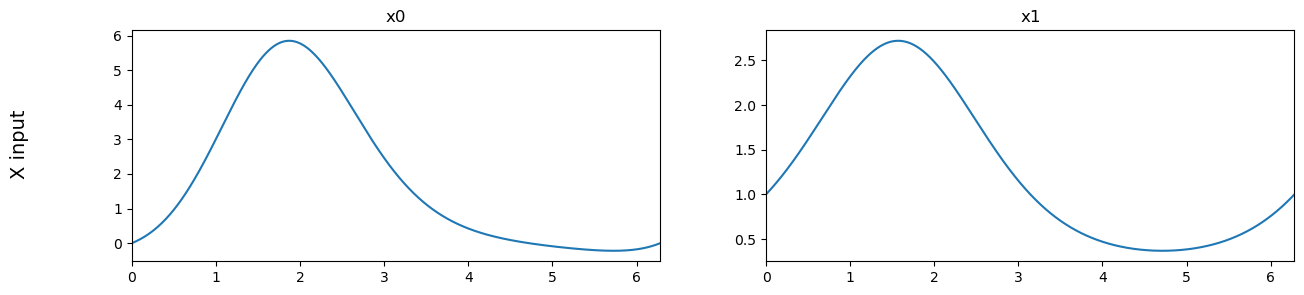

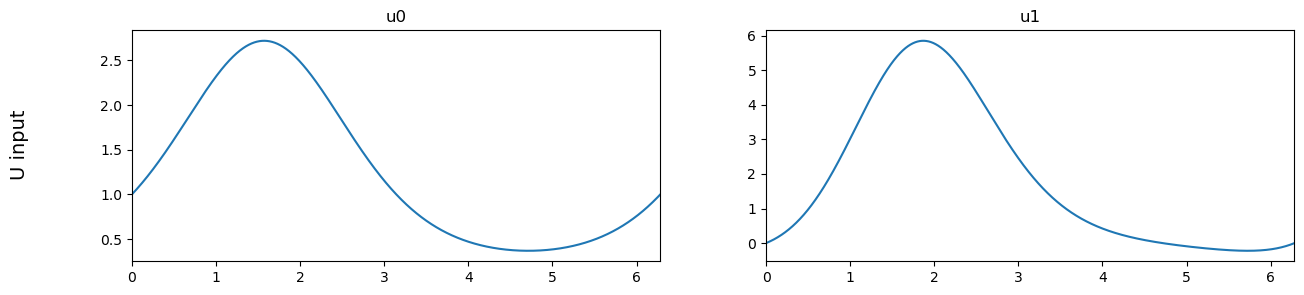

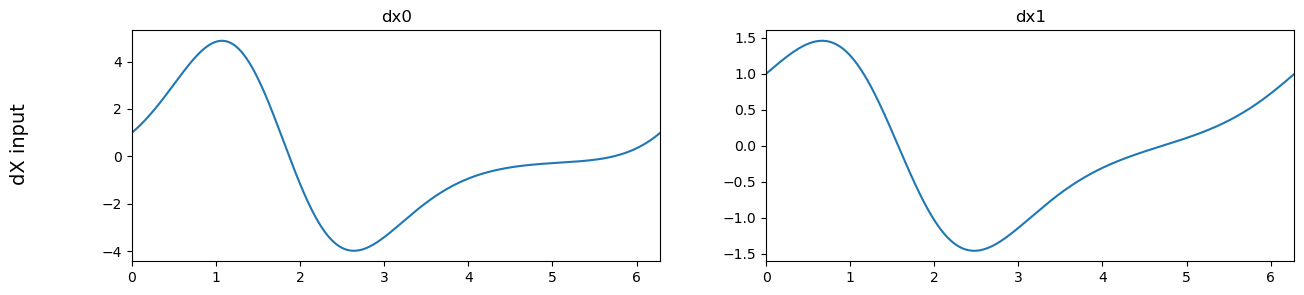

C:\Users\Egor\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


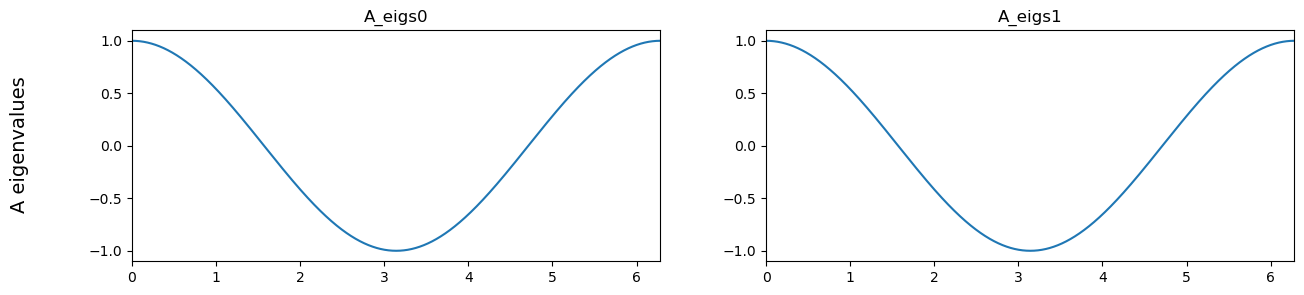

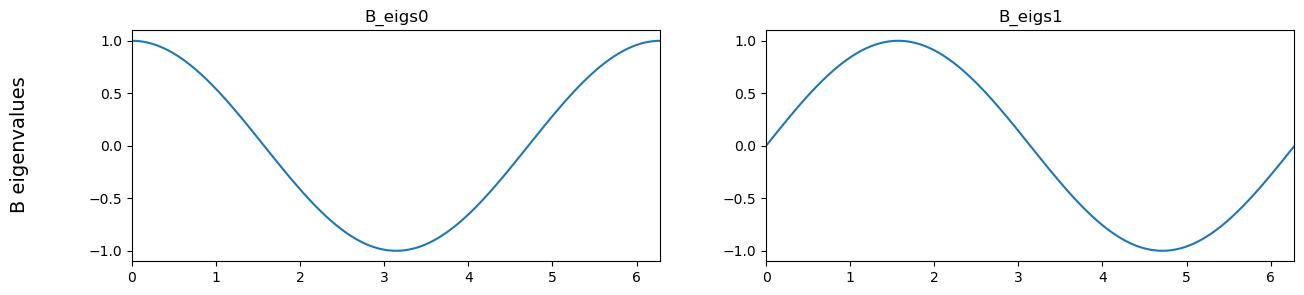

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time, x_input[:,0,:])#, label=f"lr={res.learning_rate}")
ax[0].set_title('x0')
# ax[0].legend()
ax[1].plot(time, x_input[:,1,:])#, label=f"lr={res.learning_rate}")
ax[1].set_title('x1')
# ax[1].legend()
ax[0].set_xlim(0,xlim)
ax[1].set_xlim(0,xlim)
fig.text(0.05, 0.5, 'X input', ha='center', va='center', rotation='vertical', fontsize=14)
plt.show()


fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time, u_input[:,0,:])#, label=f"lr={res.learning_rate}")
ax[0].set_title('u0')
# ax[0].legend()
ax[1].plot(time, u_input[:,1,:])#, label=f"lr={res.learning_rate}")
ax[1].set_title('u1')
# ax[1].legend()
ax[0].set_xlim(0,xlim)
ax[1].set_xlim(0,xlim)
fig.text(0.05, 0.5, 'U input', ha='center', va='center', rotation='vertical', fontsize=14)
plt.show()


fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time, dx[:,0,:])#, label=f"lr={res.learning_rate}")
ax[0].set_title('dx0')
# ax[0].legend()
ax[1].plot(time, dx[:,1,:])#, label=f"lr={res.learning_rate}")
ax[1].set_title('dx1')
# ax[1].legend()
ax[0].set_xlim(0,xlim)
ax[1].set_xlim(0,xlim)
fig.text(0.05, 0.5, 'dX input', ha='center', va='center', rotation='vertical', fontsize=14)
plt.show()


fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time, A_eigs[:,0])
ax[0].set_title('A_eigs0')
# ax[0].legend()
ax[1].plot(time, A_eigs[:,1])
ax[1].set_title('A_eigs1')
# ax[1].legend()
ax[0].set_xlim(0,xlim)
ax[1].set_xlim(0,xlim)
fig.text(0.05, 0.5, 'A eigenvalues', ha='center', va='center', rotation='vertical', fontsize=14)
plt.show()


fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time, B_eigs[:,0])
ax[0].set_title('B_eigs0')
# ax[0].legend()
ax[1].plot(time, B_eigs[:,1])
ax[1].set_title('B_eigs1')
# ax[1].legend()
ax[0].set_xlim(0,xlim)
ax[1].set_xlim(0,xlim)
fig.text(0.05, 0.5, 'B eigenvalues', ha='center', va='center', rotation='vertical', fontsize=14)
plt.show()

# Periodic identifier

In [8]:
from tqdm import tqdm

class PeriodicDNN:
    def __init__(self, state_size, u_size, k1, k2, omega, wa_init, wb_init, q_fun, r_fun, p_init, stop_time, qz=False, use_x_hat=False, omega_shift=0):
        self._state_size = state_size
        self._u_size = u_size 
        self.n_act = len(omega)
        self._one = np.array([1])
        self.omega_shift = omega_shift

        self._qz = qz
        self.use_x_hat = use_x_hat

        self.k1 = k1
        self.k2 = k2

        self.omega = omega

        self.Wa_init = wa_init
        self.Wb_init = wb_init
        
        self.Q_fun = q_fun
        self.R_fun = r_fun
        self.P_init = p_init

        self.stop_time = stop_time
        
        self._pd_check = []
        self.history_x = []
        self.history_Wa = []
        self.history_Wb = []
        self.history_P = []
        self.history_Wa_upsilon = []
        self.history_Wb_upsilon = []
        self.history_dx_dt = []
        self.history_dP_dt = []
        self.history_PRP = []
        self.history_Q = []

    def get_upsilon(self, t):
        omega = self.omega * t
        return self.omega_shift + np.reshape(np.concatenate((self._one, np.sin(omega), np.cos(omega))), (self.n_act * 2 + 1, 1))

    @staticmethod
    def fit_upsilon(upsilon, n_shape):
        return np.kron(upsilon, np.identity(n_shape))

    def law_Wa(self, P, delta, upsilon_a, x_hat):
        res = None
        res1 = None
        try:
            res = (1/self.k1)
            res = res*P
            res = res@delta
            res1 = np.transpose(upsilon_a@x_hat)
            res = res@res1
        except Exception as e:
            pprint.pprint(e)

            print('P')
            pprint.pprint(P)
            print('delta')
            pprint.pprint(delta)
            print('upsilon_a@x_hat')
            pprint.pprint(res1)

            raise e
        return res

        # return (1/self.k1)*P@delta@np.transpose(upsilon_a@x_hat)

    def law_Wb(self, P, delta, upsilon_b, u):
        res = None
        res1 = None
        try:
            res = (1/self.k2)
            res = res*P
            res = res@delta
            res1 = np.transpose(upsilon_b@u)
            res = res@res1
        except Exception as e:
            pprint.pprint(e)

            print('P')
            pprint.pprint(P)
            print('delta')
            pprint.pprint(delta)
            print('upsilon_b@u')
            pprint.pprint(res1)

            raise e
        return res
        # return (1/self.k2)*P@delta@np.transpose(upsilon_b@u)
    
    def law_PRP(self, P, Wb, upsilon_b, tk):
        Wb_upsilon = None
        BRB = None
        try:
            Wb_upsilon = Wb@upsilon_b
            BRB = Wb_upsilon@self.R_fun(tk)@Wb_upsilon.T
            res = P@BRB@P
        except Exception as e:
            pprint.pprint(e)
            print('B@R^-1@B.T')
            pprint.pprint(BRB)
            print('P')
            pprint.pprint(P)
            raise e

        return res
    
    @staticmethod
    def is_pos_def(A):
        if np.allclose(A, A.T):
            try:
                np.linalg.cholesky(A)
                return True
            except np.linalg.LinAlgError:
                return False
        else:
            return False

    def run(self, x, u, step_size, A_init=np.zeros):
        # Initialize vector
        self.history_x = []
        # cur_x = np.zeros(shape=(self._state_size, 1))
        cur_x = np.array([0.0, 1.0]).reshape((self._state_size, 1))
        self.history_x.append(cur_x.copy())
        
        # Identification error
        delta = np.zeros(x.shape)
        
        self.history_Wa = []
        cur_Wa = self.Wa_init.copy()
        self.history_Wa.append(self.Wa_init.copy())
        
        self.history_Wb = []
        cur_Wb = self.Wb_init.copy()
        self.history_Wb.append(self.Wb_init.copy())
        
        cur_P = self.P_init.copy()
        self.history_P = []
        self.history_P.append(cur_P.copy())

        self.history_loss = []

        self.history_upsilon = []
        
        for i in tqdm(range(1, len(x))):
            cur_t = i * step_size

            delta_x = x[i] - cur_x
            # print(u[i].shape)
            # print(x[i].shape)
            # print(delta_x.shape)
            self.history_loss.append(np.abs(delta_x))

            upsilon_i = self.get_upsilon((i-1)*step_size)
            upsilon_a = self.fit_upsilon(upsilon_i, self._state_size)
            upsilon_b = self.fit_upsilon(upsilon_i, self._u_size)
            
            self.history_upsilon.append(upsilon_i.copy())

            # print(upsilon_i.shape)
            # print(upsilon_a.shape)
            # print(upsilon_b.shape)

            PRP = np.zeros_like(self.P_init)
            dP_dt = np.zeros_like(self.P_init)

            if cur_t <= self.stop_time:
                # PRP = cur_P@cur_Wb@upsilon_b@self.R_fun((i-1)*step_size)@(cur_Wb@upsilon_b).T@cur_P
                PRP = self.law_PRP(P=cur_P, Wb=cur_Wb, upsilon_b=upsilon_b, tk=(i-1)*step_size)

                if self._qz:
                    cur_Q = PRP + self.Q_fun((i-1)*step_size)
                else:
                    cur_Q = self.Q_fun((i-1)*step_size)

                dP_dt = -cur_P@cur_Wa@upsilon_a - (cur_Wa@upsilon_a).T@cur_P - cur_Q + PRP
                        
            self.history_Q.append(cur_Q.copy())
            self.history_PRP.append(PRP.copy())
            self.history_dP_dt.append(dP_dt.copy())

            cur_P += step_size*dP_dt
            
            check_pd = self.is_pos_def(cur_P)
            if not check_pd:
                cur_P -= 2*step_size*dP_dt
              
            self.history_P.append(cur_P.copy())
            
            self._pd_check.append(self.is_pos_def(cur_P))
            # print(cur_P.shape)

            if cur_t <= self.stop_time:
                if self.use_x_hat:
                    dWa_dt = self.law_Wa(P=cur_P, delta=delta_x, upsilon_a=upsilon_a, x_hat=cur_x)
                else:
                    dWa_dt = self.law_Wa(P=cur_P, delta=delta_x, upsilon_a=upsilon_a, x_hat=x[i])

                dWb_dt = self.law_Wb(P=cur_P, delta=delta_x, upsilon_b=upsilon_b, u=u[i])
            else:
                dWa_dt = np.zeros_like(self.Wa_init)  # !!!!!!!!!!!!??????
                dWb_dt = np.zeros_like(self.Wb_init)  # !!!!!!!!!!!!??????

            cur_Wa += step_size*dWa_dt
            self.history_Wa.append(cur_Wa.copy())
            
            cur_Wb += step_size*dWb_dt
            self.history_Wb.append(cur_Wb.copy())
            
            Wa_upsilon = cur_Wa@upsilon_a
            Wb_upsilon = cur_Wb@upsilon_b
            self.history_Wa_upsilon.append(Wa_upsilon.copy())
            self.history_Wb_upsilon.append(Wb_upsilon.copy())
            
            dx_dt = (Wa_upsilon)@cur_x + Wb_upsilon@u[i] + A_init@delta_x
            # print(((Wa_upsilon)@x[i] + Wb_upsilon@u[i]).shape)
            # print(((A_init + Wa_upsilon)@x[i] + Wb_upsilon@u[i]).shape)
            self.history_dx_dt.append(dx_dt.copy())

            cur_x += step_size * dx_dt
            self.history_x.append(cur_x.copy())
        
        
        return np.all(self._pd_check)

\begin{equation*}
\Delta (t_{k}) = x (t_{k}) - \hat{x}(t_k)
\end{equation*}

\begin{equation*}
\frac{d}{dt}P(t_{k+1}) =- P(t_k) W_{A}(t_k) \Upsilon_{A}(t_{k}) - \left[W_{A}(t_k) \Upsilon_{A}(t_{k})\right]^\intercal P(t_k) - Q(t_k) + P(t_k) W_B(t_k) \Upsilon_{B}(t_{k}) R^{-1} (t_k) \left[ W_B(t_k) \Upsilon_{B}(t_{k}) \right]^\intercal P(t_k)
\end{equation*}


\begin{equation*}
\begin{array}{c}
\dfrac{d}{dt}\hat{W}_{A}\left( t_{k+1}\right) = k_{1}^{-1}P (t_{k+1}) \Delta \left( t_k \right) 
\left[ \Upsilon_{A} (t_{k}){x}(t_k)\right] ^{\intercal } \\
\dfrac{d}{dt}\hat{W}_{B}\left( t_{k+1}\right) = k_{2}^{-1}P (t_{k+1}) \Delta \left( t_k \right) 
\left[ \Upsilon_{B} (t_{k})u(t_k)\right] ^{\intercal }
\end{array}%
\end{equation*}


&emsp;
In case `qz` flag is `True` we take
\begin{equation*}
Q(t_k) = P(t_k) W_B(t_k) \Upsilon_{B}(t_{k}) R^{-1} (t_k)\left[ W_B(t_k) \Upsilon_{B}(t_{k}) \right]^\intercal P(t_k) + Q_0(t_k)
\end{equation*}
so the equation for $\displaystyle\frac{d}{dt}P(t_{k+1})$ becomes
\begin{equation*}
\frac{d}{dt}P(t_{k+1}) =- P(t_k) W_{A}(t_k) \Upsilon_{A}(t_{k}) - \left[W_{A}(t_k) \Upsilon_{A}(t_{k})\right]^\intercal P(t_k) - Q_0(t_k)
\end{equation*}


## Paper run



In [9]:
time_end = 9*2*np.pi
step = 0.001
time = np.arange(0,time_end,step)
x_input = xx(time)
u_input = uu(time)
xlim = 2*np.pi
# xlim = time_end

dx = np.array([AA(t)@xx(t) + BB(t)@uu(t) for t in time])

A = np.array([AA(t) for t in time])
B = np.array([BB(t) for t in time])

In [10]:
np.random.seed(42)

# omega = np.linspace(0.1, 10, 6)
# omega[-1] = 0.99
# print(omega)
omega = np.array([1])

n_act = len(omega)

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e-2,
#     'k2': 1e-4,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_init': np.identity(2)*1e-5,
#     'r_init': np.identity(2)*1e11,
#     'p_init':  np.identity(2)*8,
#     'stop_time': 1*2*np.pi
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 9*1e3,
#     'k2': 1e4,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'q_fun': lambda t: np.identity(2)*0, # 10*(1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: np.identity(2)*1e6, # lambda t:  1e10*(1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': 0.17*time_end,
#     'qz': True,
#     }

################################################################################
## Somehow working params
# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e2,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'q_fun': lambda t: 1e-1 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1e-2 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': time_end,
#     'qz': True,
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e0,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_fun': lambda t: 1e-10 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.array([[10.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': 0.45*time_end,
#     'qz': True,
#     'use_x_hat': False
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e0,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_fun': lambda t: 1e-10 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.array([[10.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': time_end,
#     'qz': True,
#     'use_x_hat': False
#     }

dnn_params = {
    'state_size': 2,
    'u_size': 2,
    'k1': 1e0,
    'k2': 1e-1,
    'omega': omega,
    'wa_init': np.random.rand(2, 2*(2*n_act + 1)) * 1e-1,
    'wb_init': np.random.rand(2, 2*(2*n_act + 1)) * 1e-1,
    'q_fun': lambda t: 1e-5 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
    'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
    'p_init':  np.array([[20.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
    # 'stop_time': 1*2*np.pi,
    'stop_time': time_end,
    'qz': True,
    'use_x_hat': False,
    'omega_shift': 0
    }

In [15]:
dnn = PeriodicDNN(**dnn_params)
# default_settings = {'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}
# np.seterr(**default_settings)
np.seterr(all='raise')


a_init = np.array([[2, 0],[0, 5]])*25
result = dnn.run(x=x_input, u=u_input, step_size=step, A_init=a_init)

print()
print(result)

100%|██████████| 56548/56548 [00:10<00:00, 5207.65it/s]


True


In [16]:
loss_norm = np.sum(np.linalg.norm(dnn.history_loss, axis=1))
loss_delta = np.sum(list(map(lambda el: np.transpose(el)@el, dnn.history_loss)))

print(f"Loss Norm:\t{loss_norm}")
print(f"Loss Delta:\t{loss_delta}")


Loss Norm:	123.46276372234541
Loss Delta:	0.4397711352407013


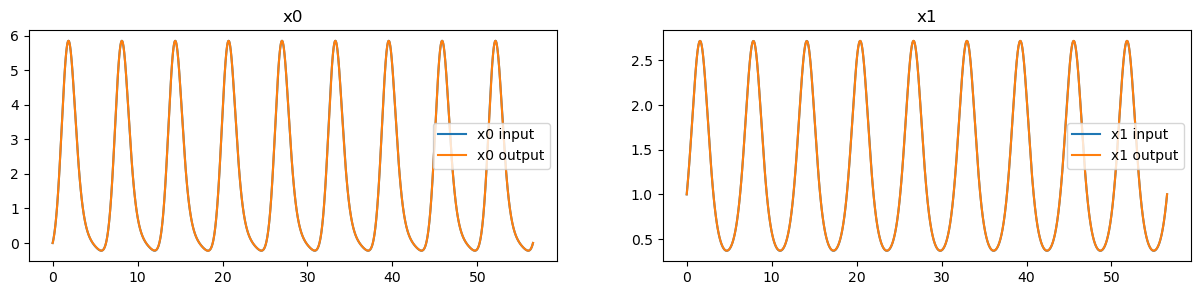

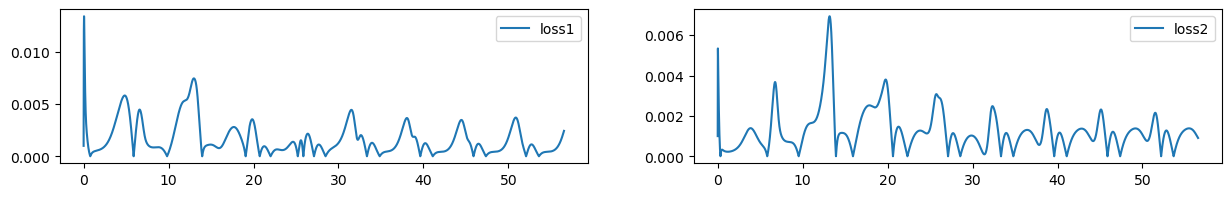

In [17]:
x = np.array(dnn.history_x)
loss = np.array(dnn.history_loss)

fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time, x_input[:,0,:], label=f"x0 input")
ax[0].plot(time, x[:,0,:], label=f"x0 output")
ax[0].set_title('x0')
ax[0].legend()
# ax[0].set_ylim([-6, 6])

ax[1].plot(time, x_input[:,1,:], label=f"x1 input")
ax[1].plot(time, x[:,1,:], label=f"x1 output")
ax[1].set_title('x1')
ax[1].legend()
# ax[1].set_ylim([-6, 3.3])
plt.show()


fig, ax = plt.subplots(ncols=2, figsize=(15, 2), sharex=True, sharey=False)
ax[0].plot(time[:-1], loss[:,0,:], label=f"loss1")
ax[0].legend()
ax[1].plot(time[:-1], loss[:,1,:], label=f"loss2")
ax[1].legend()
plt.show()



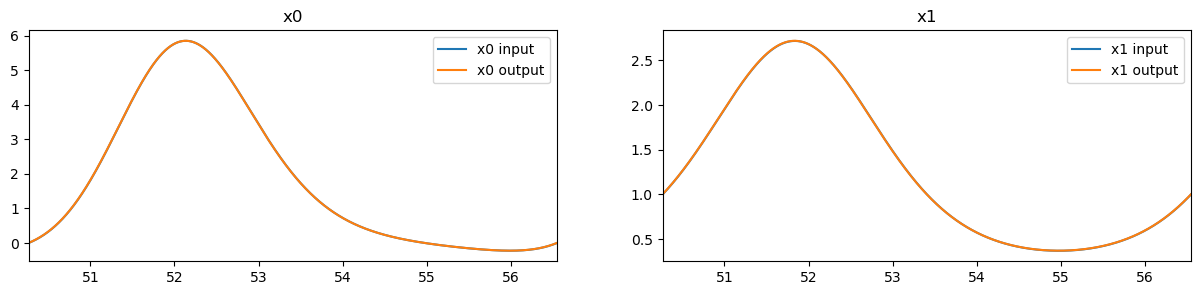

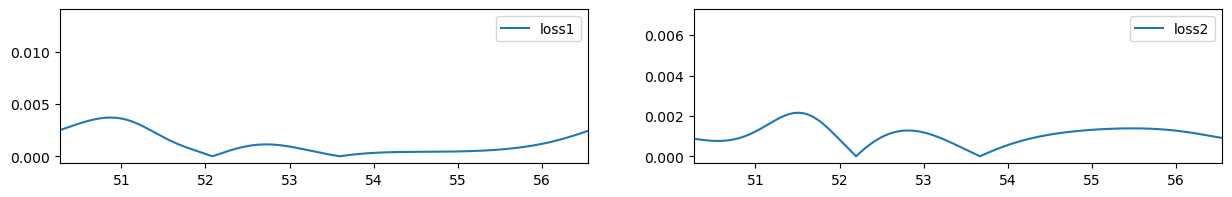

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time, x_input[:,0,:], label=f"x0 input")
ax[0].plot(time, x[:,0,:], label=f"x0 output")
ax[0].set_title('x0')
ax[0].legend()

ax[1].plot(time, x_input[:,1,:], label=f"x1 input")
ax[1].plot(time, x[:,1,:], label=f"x1 output")
ax[1].set_title('x1')
ax[1].legend()
# ax[1].set_ylim([-2, 2])

ax[0].set_xlim(time_end - xlim,time_end)
ax[1].set_xlim(time_end - xlim,time_end)

# ax[0].set_xlim(0,xlim)
# ax[1].set_xlim(0,xlim)

# ax[0].set_ylim([-2, 20])
# ax[1].set_ylim([-2, 20])

# ax[0].set_xlim(0, xlim)
# ax[1].set_xlim(0, xlim)

plt.show()


fig, ax = plt.subplots(ncols=2, figsize=(15, 2), sharex=True, sharey=False)
ax[0].plot(time[:-1], loss[:,0,:], label=f"loss1")
ax[0].legend()
ax[1].plot(time[:-1], loss[:,1,:], label=f"loss2")
ax[1].legend()
ax[0].set_xlim(time_end - xlim,time_end)
ax[1].set_xlim(time_end - xlim,time_end)

plt.show()

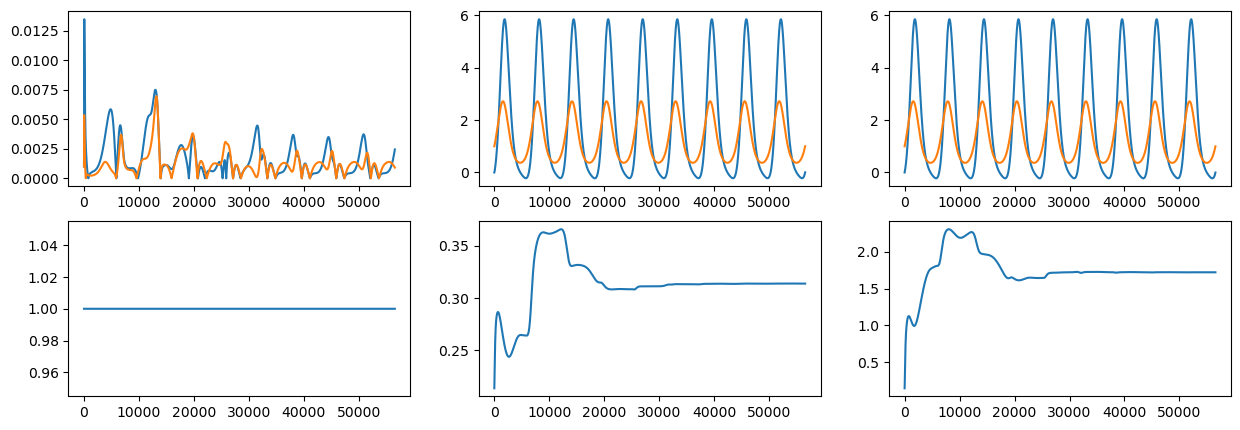

In [19]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 5), sharex=False, sharey=False)
ax[0, 0].plot(np.squeeze(loss))
ax[0, 1].plot(np.squeeze(x))
ax[0, 2].plot(np.squeeze(x_input))
ax[1, 0].plot(np.array(dnn._pd_check))
ax[1, 1].plot(np.linalg.norm(dnn.history_Wa, axis=(1,2)))
ax[1, 2].plot(np.linalg.norm(dnn.history_Wb, axis=(1,2)))

# ax[1, 0].set_ylim(-5,5)
# ax[1, 1].set_ylim(-5,5)
# ax[1, 2].set_ylim(-5,5)
# ax[0, 0].set_ylim(-5,5)
# ax[0, 1].set_ylim(-5,5)
# ax[0, 2].set_ylim(-5,5)

plt.show()



In [20]:
def get_upsilon_title(i, j):
    if j == 0:
        return f"$\sin{{\omega_{{{i}}} t}}$"
    else:
        return f"$\cos{{\omega_{{{i}}} t}}$"

get_label = lambda x,i,j: f"${{{x}}}"+f"_{{{i}, {j}}}$"
get_a_label = lambda i,j: get_label('A', i, j)
get_b_label = lambda i,j: get_label('B', i, j)
get_weights_a_label = lambda i,j: get_label('\check{W}_{{A}} \\Upsilon_{{A}}', i, j) 
get_weights_b_label = lambda i,j: get_label('\check{W}_{{B}} \\Upsilon_{{B}}', i, j) 


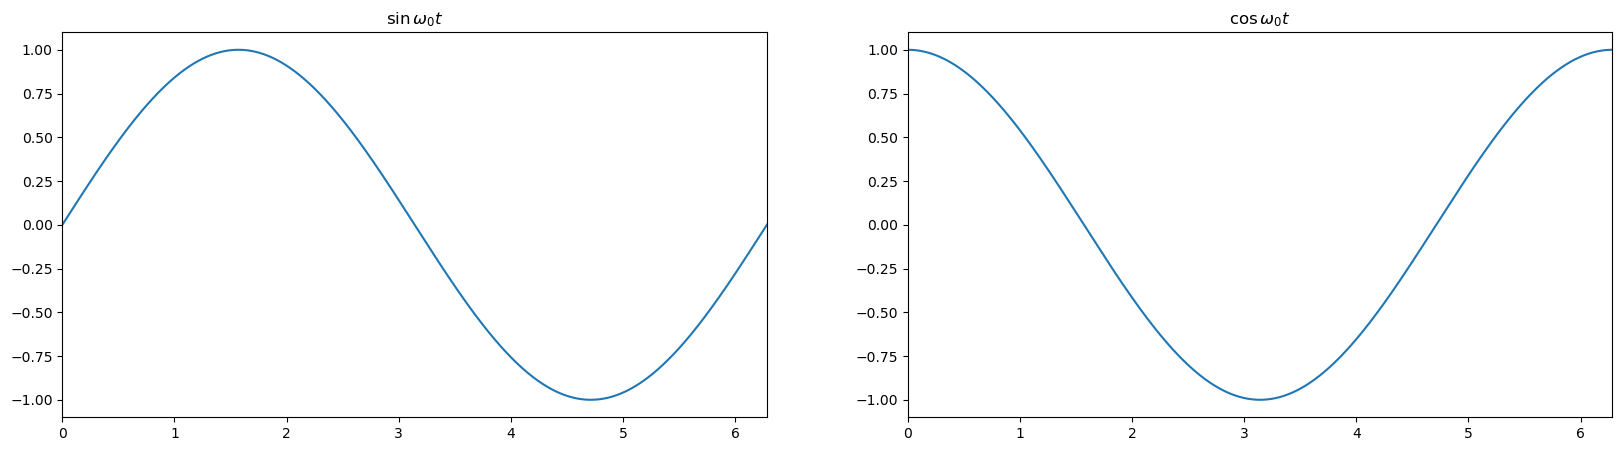

In [21]:
upsilon = np.squeeze(dnn.history_upsilon)
cols = 2
fig, ax = plt.subplots(nrows=dnn.n_act, ncols=cols, figsize=(20, 5), sharex=True, sharey=False)
if dnn.n_act == 1:
    ax = ax.reshape(1, cols)

for i in range(dnn.n_act):
    for j in range(0, cols):
        # print(i + j*dnn.n_act)
        ax[i, j].plot(time[:-1], upsilon[:,1 + i + j*dnn.n_act])
        ax[i, j].set_title(get_upsilon_title(i, j))
        ax[i, j].set_xlim(0,xlim)

plt.show()


In [22]:
omega

array([1])

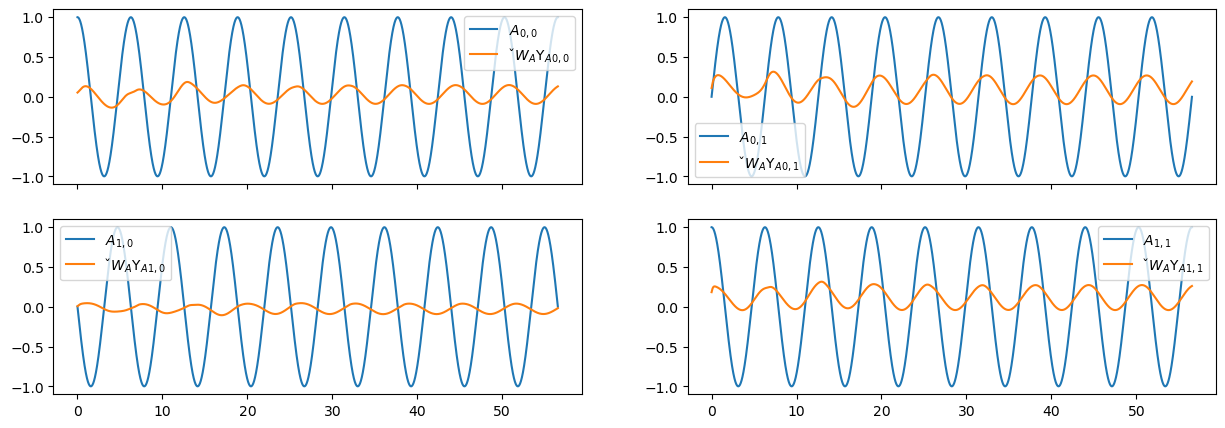

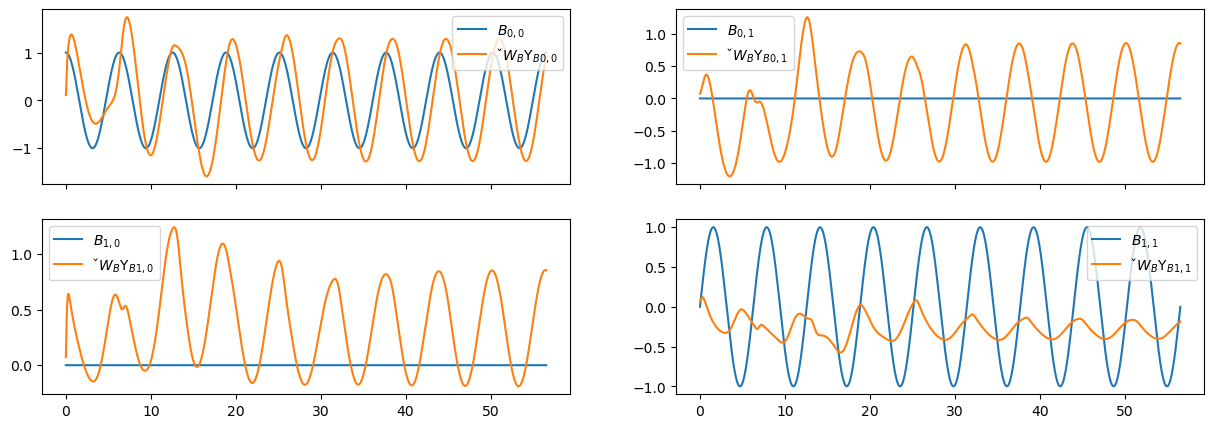

In [24]:
Wa_ups = np.array(dnn.history_Wa_upsilon)
Wb_ups = np.array(dnn.history_Wb_upsilon)

fig, ax = plt.subplots(nrows=dnn._state_size, ncols=dnn._state_size, figsize=(15, 5), sharex=True, sharey=False)
for i in range(dnn._state_size):
    for j in range(dnn._state_size):
        ax[i, j].plot(time, A[:,i,j], label=get_a_label(i,j))
        ax[i, j].plot(time[:-1], Wa_ups[:,i,j], label=get_weights_a_label(i,j))
        ax[i, j].legend()
        # ax[i, j].set_xlim(0,xlim)
        # ax[i, j].set_ylim([-10, 10])
plt.show()


fig, ax = plt.subplots(nrows=dnn._u_size, ncols=dnn._u_size, figsize=(15, 5), sharex=True, sharey=False)
for i in range(dnn._u_size):
    for j in range(dnn._u_size):
        ax[i, j].plot(time, B[:,i,j], label=get_b_label(i,j))
        ax[i, j].plot(time[:-1], Wb_ups[:,i,j], label=get_weights_b_label(i,j))
        ax[i, j].legend()
        # ax[i, j].set_xlim(0,xlim)
        # ax[i, j].set_ylim([-10, 10])
plt.show()

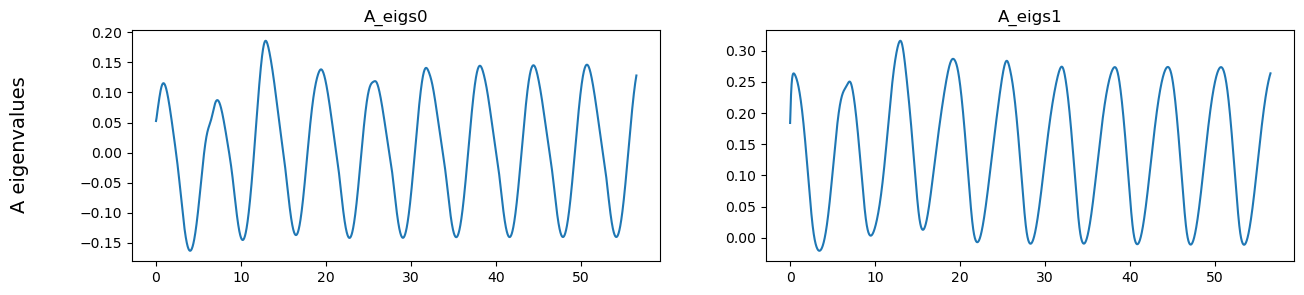

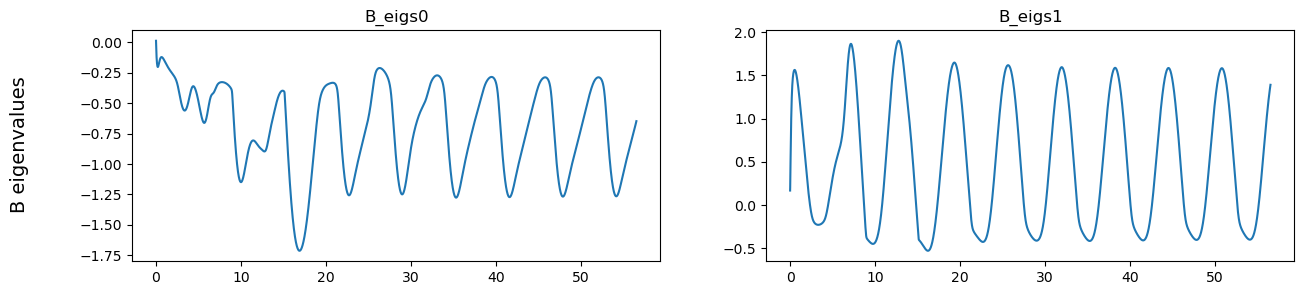

In [25]:
tk = int(time_end / step -1)

Wa_eigs = np.linalg.eigh(Wa_ups[:tk])[0]

fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time[:tk], Wa_eigs[:tk,0])
ax[0].set_title('A_eigs0')
# ax[0].legend()
ax[1].plot(time[:tk], Wa_eigs[:tk,1])
ax[1].set_title('A_eigs1')
# ax[1].legend()
fig.text(0.05, 0.5, 'A eigenvalues', ha='center', va='center', rotation='vertical', fontsize=14)
plt.show()

Wb_eigs = np.linalg.eigh(Wb_ups[:tk])[0]
fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time[:tk], Wb_eigs[:tk,0])
ax[0].set_title('B_eigs0')
# ax[0].legend()
ax[1].plot(time[:tk], Wb_eigs[:tk,1])
ax[1].set_title('B_eigs1')
# ax[1].legend()
fig.text(0.05, 0.5, 'B eigenvalues', ha='center', va='center', rotation='vertical', fontsize=14)
plt.show()

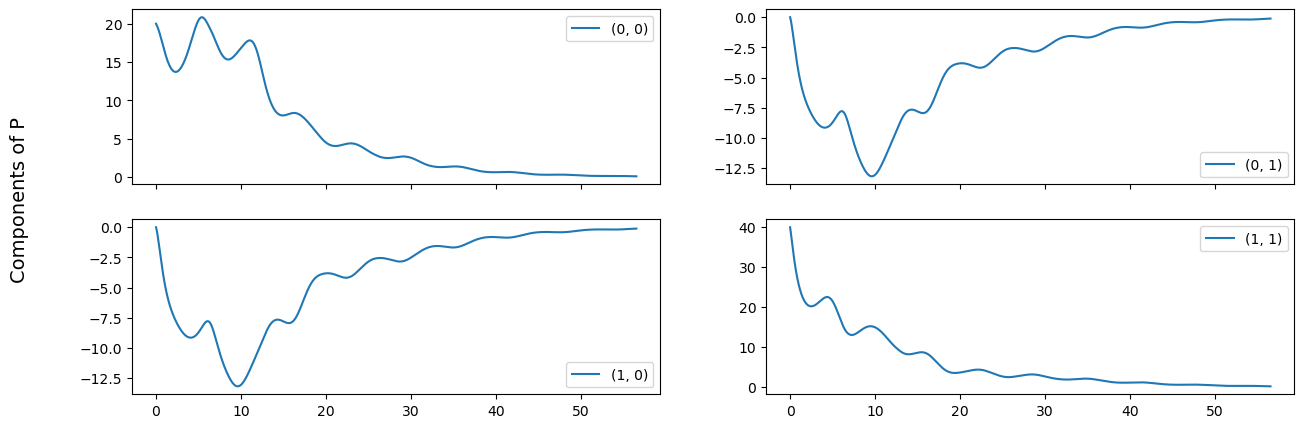

In [29]:
P = np.array(dnn.history_P)

fig, ax = plt.subplots(nrows=dnn._state_size, ncols=dnn._state_size, figsize=(15, 5), sharex=True, sharey=False)
for i in range(dnn._state_size):
    for j in range(dnn._state_size):
        ax[i, j].plot(time, P[:,i,j], label=f"{(i,j)}")
        ax[i, j].legend()
        # ax[i, j].set_ylim([-10, 10])

fig.text(0.05, 0.5, 'Components of P', ha='center', va='center', rotation='vertical', fontsize=14)
plt.show()

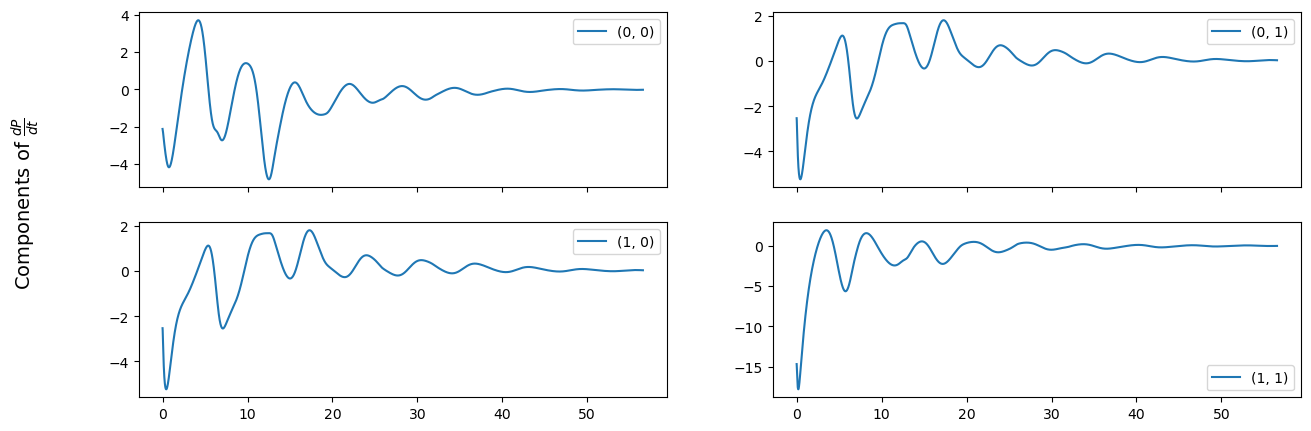

In [30]:
dP = np.array(dnn.history_dP_dt)

fig, ax = plt.subplots(nrows=dnn._state_size, ncols=dnn._state_size, figsize=(15, 5), sharex=True, sharey=False)
for i in range(dnn._state_size):
    for j in range(dnn._state_size):
        ax[i, j].plot(time[:-1], dP[:,i,j], label=f"{(i,j)}")
        ax[i, j].legend()
        # ax[i, j].set_ylim([-10, 10])

fig.text(0.05, 0.5, 'Components of $\\frac{{dP}}{{dt}}$', ha='center', va='center', rotation='vertical', fontsize=14)
plt.show()

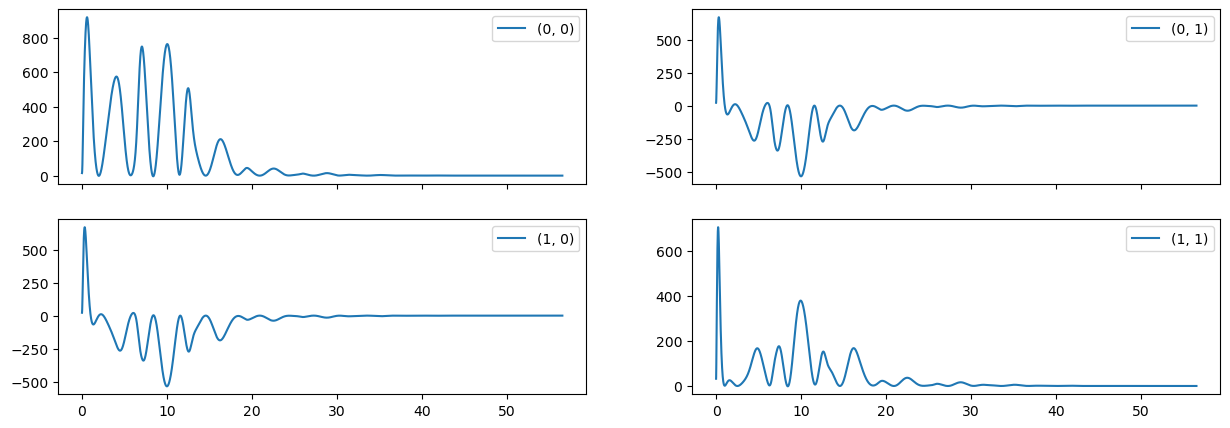

In [31]:
PRP = np.array(dnn.history_PRP)

fig, ax = plt.subplots(nrows=dnn._state_size, ncols=dnn._state_size, figsize=(15, 5), sharex=True, sharey=False)
for i in range(dnn._state_size):
    for j in range(dnn._state_size):
        ax[i, j].plot(time[:-1], PRP[:,i,j], label=f"{(i,j)}")
        ax[i, j].legend()
        # ax[i, j].set_ylim([-5, 5])
plt.show()

$$P(t_k) W_B(t_k) \Upsilon_{B}(t_{k}) R^{-1} (t_k) \left[ W_B(t_k) \Upsilon_{B}(t_{k}) \right] P(t_k)$$


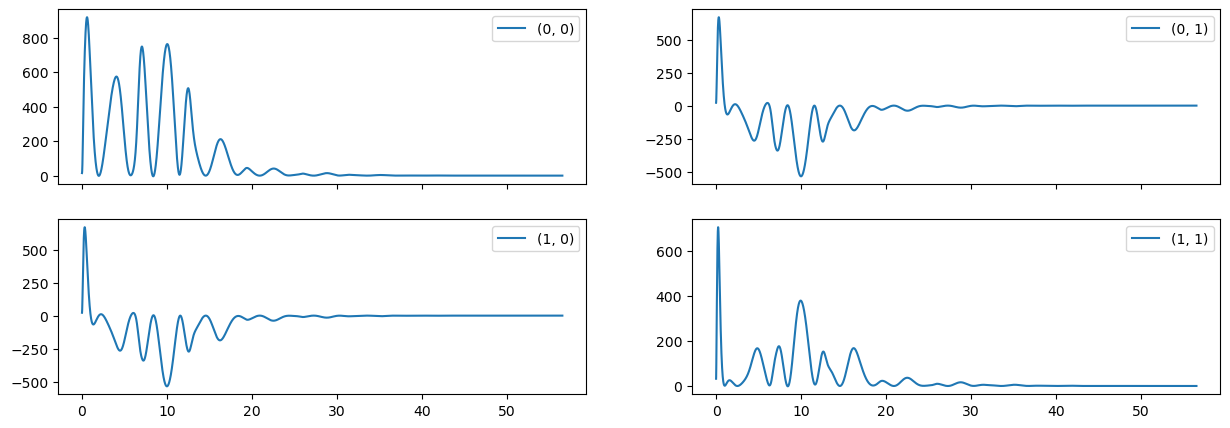

In [32]:
Q_0 = np.array(dnn.history_Q)

fig, ax = plt.subplots(nrows=dnn._state_size, ncols=dnn._state_size, figsize=(15, 5), sharex=True, sharey=False)
for i in range(dnn._state_size):
    for j in range(dnn._state_size):
        ax[i, j].plot(time[:-1], Q_0[:,i,j], label=f"{(i,j)}")
        ax[i, j].legend()
        # ax[i, j].set_ylim([-10, 10])
plt.show()

## Add noise to input

In [33]:
noise = np.array([[0.05,0],[0,0.006]])@np.random.normal(0, 1, x_input.shape)

In [34]:
noise.shape

(56549, 2, 1)

In [38]:
import seaborn as sns

C:\Users\Egor\AppData\Local\Temp\ipykernel_1932\2296015811.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(noise, bins=40, hist_kws={'edgecolor':'black'})


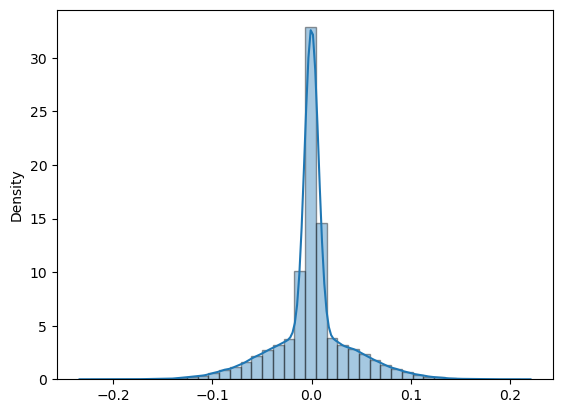

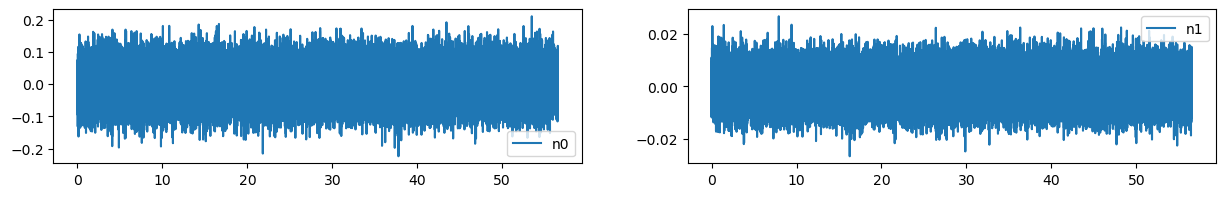

In [39]:
sns.distplot(noise, bins=40, hist_kws={'edgecolor':'black'})

fig, ax = plt.subplots(ncols=2, figsize=(15, 2), sharex=True, sharey=False)
ax[0].plot(time, noise[:,0,:], label=f"n0")
ax[0].legend()
ax[1].plot(time, noise[:,1,:], label=f"n1")
ax[1].legend()
plt.show()

In [40]:
noisy_input = x_input + noise

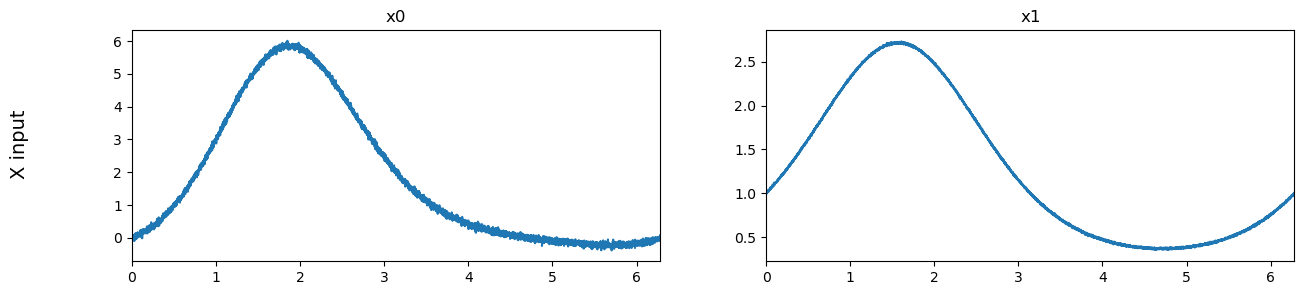

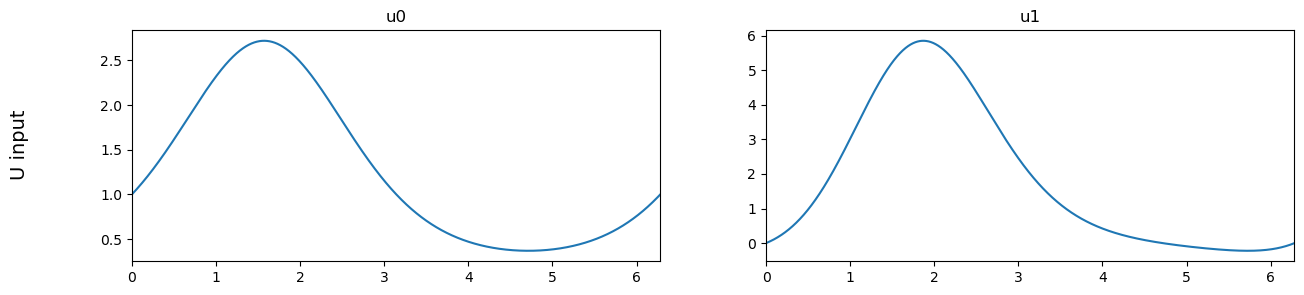

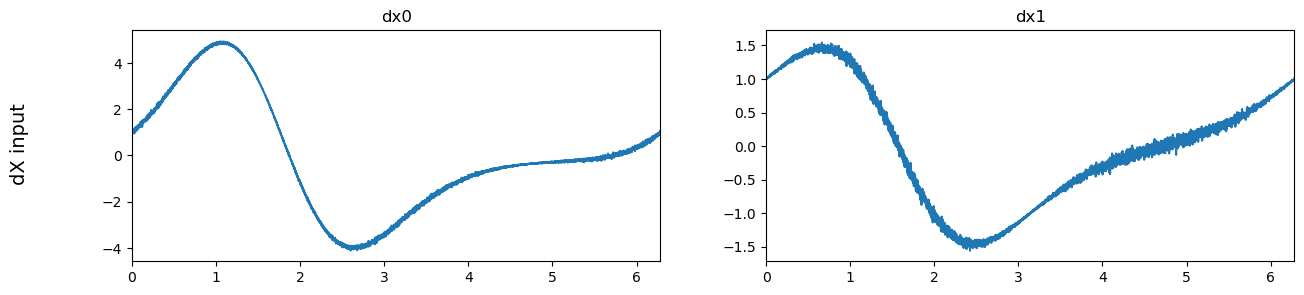

In [41]:
xlim = 2*np.pi

fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time, noisy_input[:,0,:])#, label=f"lr={res.learning_rate}")
ax[0].set_title('x0')
ax[0].set_xlim(0,xlim)
# ax[0].legend()
ax[1].plot(time, noisy_input[:,1,:])#, label=f"lr={res.learning_rate}")
ax[1].set_title('x1')
ax[1].set_xlim(0,xlim)
# ax[1].legend()
fig.text(0.05, 0.5, 'X input', ha='center', va='center', rotation='vertical', fontsize=14)
plt.show()

fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time, u_input[:,0,:])#, label=f"lr={res.learning_rate}")
ax[0].set_title('u0')
ax[1].set_xlim(0,xlim)
# ax[0].legend()
ax[1].plot(time, u_input[:,1,:])#, label=f"lr={res.learning_rate}")
ax[1].set_title('u1')
ax[1].set_xlim(0,xlim)
# ax[1].legend()
fig.text(0.05, 0.5, 'U input', ha='center', va='center', rotation='vertical', fontsize=14)
plt.show()


dx = np.array([AA(t)@(xx(t) + noise[i]) + BB(t)@uu(t) for i, t in enumerate(time)])

fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time, dx[:,0,:])#, label=f"lr={res.learning_rate}")
ax[0].set_title('dx0')
ax[0].set_xlim(0,xlim)
ax[1].plot(time, dx[:,1,:])#, label=f"lr={res.learning_rate}")
ax[1].set_title('dx1')
ax[1].set_xlim(0,xlim)
# ax[1].legend()
fig.text(0.05, 0.5, 'dX input', ha='center', va='center', rotation='vertical', fontsize=14)
plt.show()

In [42]:
# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e-2,
#     'k2': 1e-4,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_init': np.identity(2)*1e-5,
#     'r_init': np.identity(2)*1e11,
#     'p_init':  np.identity(2)*8,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': time_end,
#     'qz': False,
#     }

dnn_noise_params = dnn_params
# dnn_noise_params['k1'] = 1e-3
# dnn_noise_params['k2'] = 1e4

np.random.seed(42)


dnn = PeriodicDNN(**dnn_noise_params)


result = dnn.run(x=noisy_input, u=u_input, step_size=step, A_init=a_init)

print()
print(result)

100%|██████████| 56548/56548 [00:10<00:00, 5303.96it/s]


True


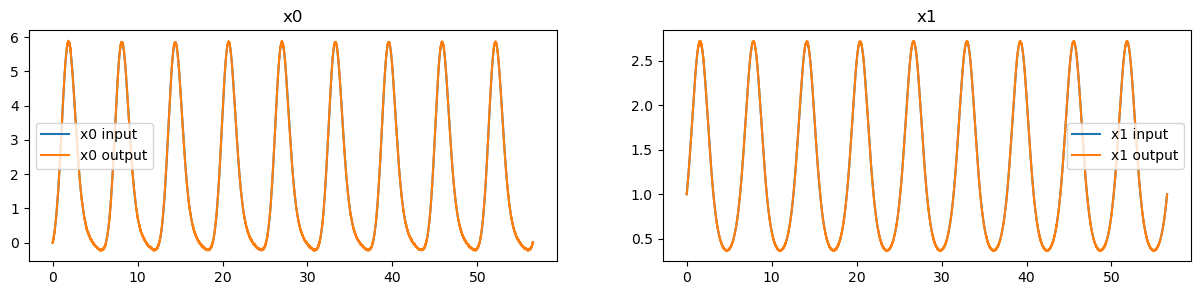

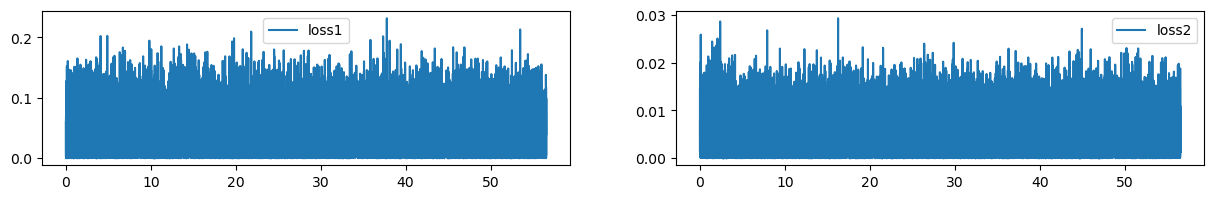

In [43]:
x = np.array(dnn.history_x)
loss = np.array(dnn.history_loss)

fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time, x_input[:,0,:], label=f"x0 input")
ax[0].plot(time, x[:,0,:], label=f"x0 output")
ax[0].set_title('x0')
ax[0].legend()
# ax[0].set_ylim([-2, 10])

ax[1].plot(time, x_input[:,1,:], label=f"x1 input")
ax[1].plot(time, x[:,1,:], label=f"x1 output")
ax[1].set_title('x1')
ax[1].legend()
# ax[1].set_ylim([-2, 2])
plt.show()


fig, ax = plt.subplots(ncols=2, figsize=(15, 2), sharex=True, sharey=False)
ax[0].plot(time[:-1], loss[:,0,:], label=f"loss1")
ax[0].legend()
ax[1].plot(time[:-1], loss[:,1,:], label=f"loss2")
ax[1].legend()
plt.show()

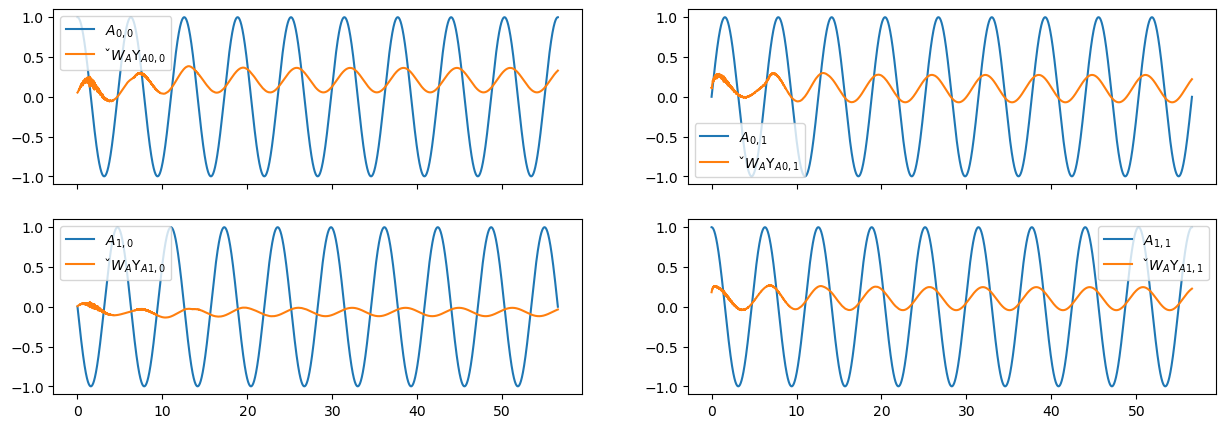

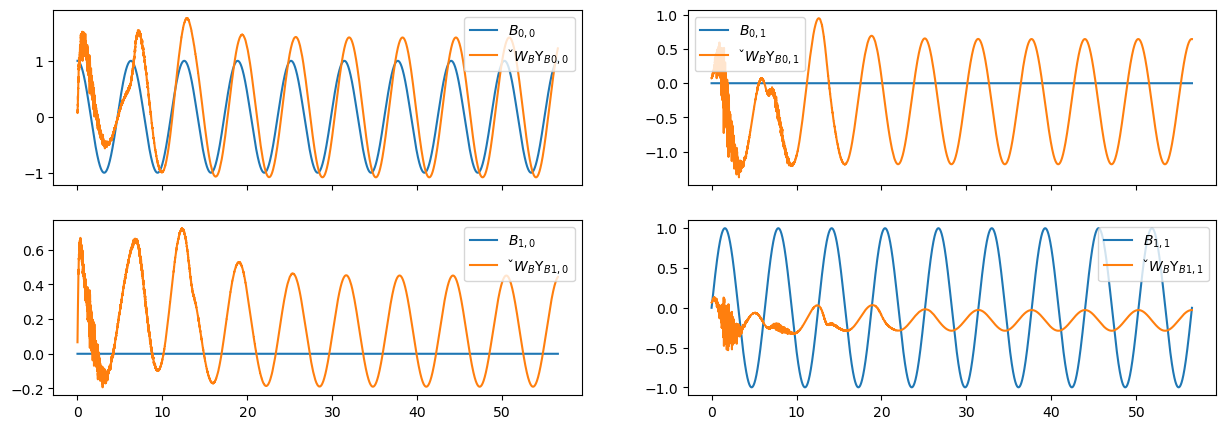

In [44]:
Wa_ups = np.array(dnn.history_Wa_upsilon)
Wb_ups = np.array(dnn.history_Wb_upsilon)

fig, ax = plt.subplots(nrows=dnn._state_size, ncols=dnn._state_size, figsize=(15, 5), sharex=True, sharey=False)
for i in range(dnn._state_size):
    for j in range(dnn._state_size):
        ax[i, j].plot(time, A[:,i,j], label=get_a_label(i,j))
        ax[i, j].plot(time[:-1], Wa_ups[:,i,j], label=get_weights_a_label(i,j))
        ax[i, j].legend()
        # ax[i, j].set_ylim([-10, 10])
plt.show()


fig, ax = plt.subplots(nrows=dnn._u_size, ncols=dnn._u_size, figsize=(15, 5), sharex=True, sharey=False)
for i in range(dnn._u_size):
    for j in range(dnn._u_size):
        ax[i, j].plot(time, B[:,i,j], label=get_b_label(i,j))
        ax[i, j].plot(time[:-1], Wb_ups[:,i,j], label=get_weights_b_label(i,j))
        ax[i, j].legend()
        # ax[i, j].set_ylim([-10, 10])
plt.show()

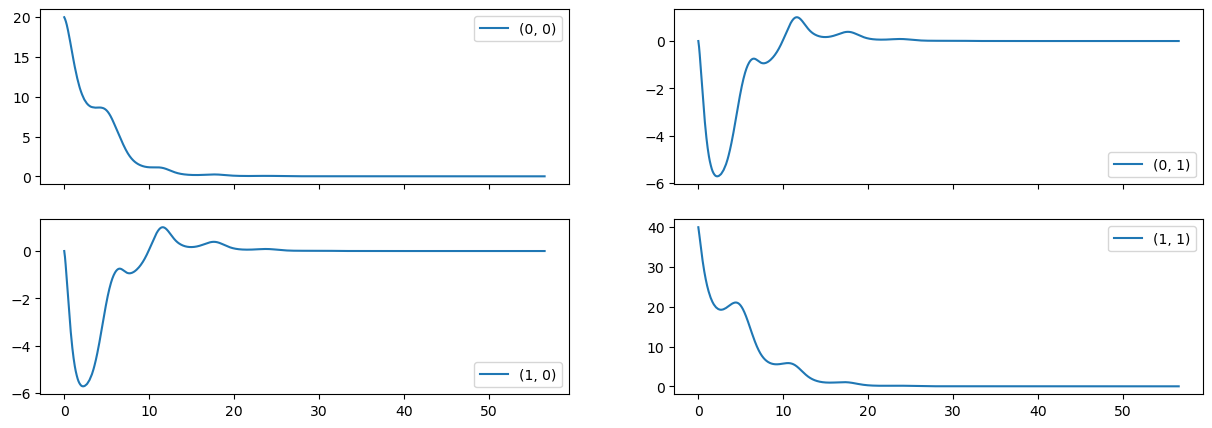

In [48]:
P = np.array(dnn.history_P)

fig, ax = plt.subplots(nrows=dnn._state_size, ncols=dnn._state_size, figsize=(15, 5), sharex=True, sharey=False)
for i in range(dnn._state_size):
    for j in range(dnn._state_size):
        ax[i, j].plot(time, P[:,i,j], label=f"{(i,j)}")
        ax[i, j].legend()
        # ax[i, j].set_ylim([-10, 10])
plt.show()

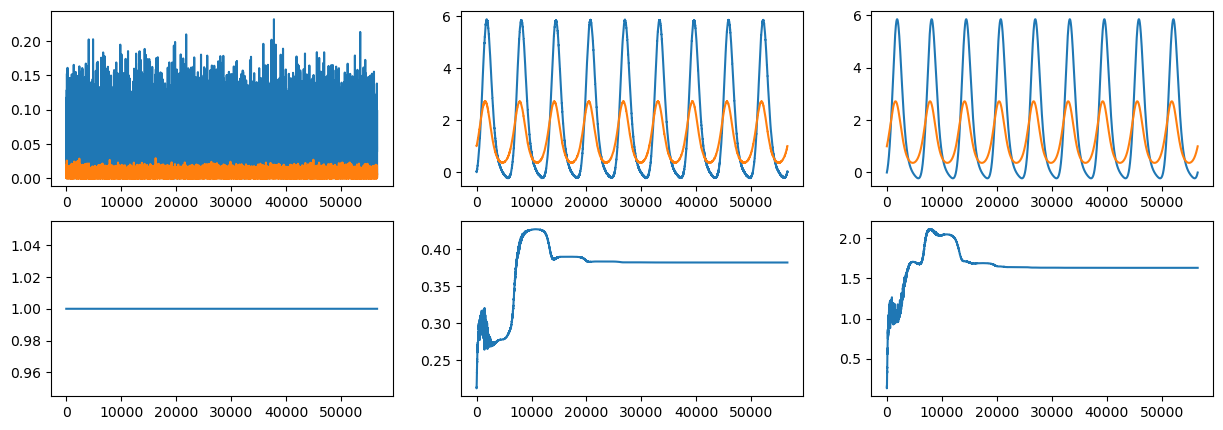

In [46]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 5), sharex=False, sharey=False)
ax[0, 0].plot(np.squeeze(loss))
ax[0, 1].plot(np.squeeze(x))
ax[0, 2].plot(np.squeeze(x_input))
ax[1, 0].plot(np.array(dnn._pd_check))
ax[1, 1].plot(np.linalg.norm(dnn.history_Wa, axis=(1,2)))
ax[1, 2].plot(np.linalg.norm(dnn.history_Wb, axis=(1,2)))

# ax[1, 0].set_ylim(-5,5)
# ax[1, 1].set_ylim(-5,5)
# ax[1, 2].set_ylim(-5,5)
# ax[0, 0].set_ylim(-5,5)
# ax[0, 1].set_ylim(-5,5)
# ax[0, 2].set_ylim(-5,5)

plt.show()

In [47]:
dnn.history_P[-1]

array([[ 1.65349716e-05, -3.48236604e-06],
       [-3.48236604e-06,  7.63048272e-07]])

# Constant matrix P

In [49]:
class DNN_P_const:
    def __init__(self, state_size, u_size, k1, k2, omega, wa_init, wb_init, q_fun, r_fun, p_init, stop_time, qz=False, use_x_hat=False, omega_shift=0):
        self._state_size = state_size
        self._u_size = u_size 
        self.n_act = len(omega)
        self._one = np.array([1])
        self.omega_shift = omega_shift

        self._qz = qz
        self.use_x_hat = use_x_hat

        self.k1 = k1
        self.k2 = k2

        self.omega = omega

        self.Wa_init = wa_init
        self.Wb_init = wb_init
        
        self.Q_fun = q_fun
        self.R_fun = r_fun
        self.P_init = p_init

        self.stop_time = stop_time
        
        self._pd_check = []
        self.history_x = []
        self.history_Wa = []
        self.history_Wb = []
        self.history_P = []
        self.history_Wa_upsilon = []
        self.history_Wb_upsilon = []
        self.history_dx_dt = []
        self.history_dP_dt = []
        self.history_PRP = []
        self.history_Q = []

    def get_upsilon(self, t):
        omega = self.omega * t
        return self.omega_shift + np.reshape(np.concatenate((self._one, np.sin(omega), np.cos(omega))), (self.n_act * 2 + 1, 1))

    @staticmethod
    def fit_upsilon(upsilon, n_shape):
        return np.kron(upsilon, np.identity(n_shape))

    def law_Wa(self, P, delta, upsilon_a, x_hat):
        res = None
        res1 = None
        try:
            res = (1/self.k1)
            res = res*P
            res = res@delta
            res1 = np.transpose(upsilon_a@x_hat)
            res = res@res1
        except Exception as e:
            pprint.pprint(e)

            print('P')
            pprint.pprint(P)
            print('delta')
            pprint.pprint(delta)
            print('upsilon_a@x_hat')
            pprint.pprint(res1)

            raise e
        return res

        # return (1/self.k1)*P@delta@np.transpose(upsilon_a@x_hat)

    def law_Wb(self, P, delta, upsilon_b, u):
        res = None
        res1 = None
        try:
            res = (1/self.k2)
            res = res*P
            res = res@delta
            res1 = np.transpose(upsilon_b@u)
            res = res@res1
        except Exception as e:
            pprint.pprint(e)

            print('P')
            pprint.pprint(P)
            print('delta')
            pprint.pprint(delta)
            print('upsilon_b@u')
            pprint.pprint(res1)

            raise e
        return res
        # return (1/self.k2)*P@delta@np.transpose(upsilon_b@u)
    
    def law_PRP(self, P, Wb, upsilon_b, tk):
        Wb_upsilon = None
        BRB = None
        try:
            Wb_upsilon = Wb@upsilon_b
            BRB = Wb_upsilon@self.R_fun(tk)@Wb_upsilon.T
            res = P@BRB@P
        except Exception as e:
            pprint.pprint(e)
            print('B@R^-1@B.T')
            pprint.pprint(BRB)
            print('P')
            pprint.pprint(P)
            raise e

        return res
    
    @staticmethod
    def is_pos_def(A):
        if np.allclose(A, A.T):
            try:
                np.linalg.cholesky(A)
                return True
            except np.linalg.LinAlgError:
                return False
        else:
            return False

    def run(self, x, u, step_size, A_init=np.zeros):
        # Initialize vector
        self.history_x = []
        # cur_x = np.zeros(shape=(self._state_size, 1))
        cur_x = np.array([0.0, 1.0]).reshape((self._state_size, 1))
        self.history_x.append(cur_x.copy())
        
        # Identification error
        delta = np.zeros(x.shape)
        
        self.history_Wa = []
        cur_Wa = self.Wa_init.copy()
        self.history_Wa.append(self.Wa_init.copy())
        
        self.history_Wb = []
        cur_Wb = self.Wb_init.copy()
        self.history_Wb.append(self.Wb_init.copy())
        
        cur_P = self.P_init.copy()
        self.history_P = []
        self.history_P.append(cur_P.copy())

        self.history_loss = []

        self.history_upsilon = []
        
        for i in tqdm(range(1, len(x))):
            cur_t = i * step_size

            delta_x = x[i] - cur_x
            # print(u[i].shape)
            # print(x[i].shape)
            # print(delta_x.shape)
            self.history_loss.append(np.abs(delta_x))

            upsilon_i = self.get_upsilon((i-1)*step_size)
            upsilon_a = self.fit_upsilon(upsilon_i, self._state_size)
            upsilon_b = self.fit_upsilon(upsilon_i, self._u_size)
            
            self.history_upsilon.append(upsilon_i.copy())

            # print(upsilon_i.shape)
            # print(upsilon_a.shape)
            # print(upsilon_b.shape)
            
            """
            if i == 1:
                PRP = np.zeros_like(self.P_init)
                dP_dt = np.zeros_like(self.P_init)

                if cur_t <= self.stop_time:
                    # PRP = cur_P@cur_Wb@upsilon_b@self.R_fun((i-1)*step_size)@(cur_Wb@upsilon_b).T@cur_P
                    PRP = self.law_PRP(P=cur_P, Wb=cur_Wb, upsilon_b=upsilon_b, tk=(i-1)*step_size)

                    if self._qz:
                        cur_Q = PRP + self.Q_fun((i-1)*step_size)
                    else:
                        cur_Q = self.Q_fun((i-1)*step_size)

                dP_dt = -cur_P@cur_Wa@upsilon_a - (cur_Wa@upsilon_a).T@cur_P - cur_Q + PRP
            """
            
            """
            self.history_Q.append(cur_Q.copy())
            self.history_PRP.append(PRP.copy())
            self.history_dP_dt.append(dP_dt.copy())

            cur_P += step_size*dP_dt
            
            check_pd = self.is_pos_def(cur_P)
            if not check_pd:
                cur_P -= 2*step_size*dP_dt
            """  
            
            self.history_P.append(cur_P.copy())
            
            self._pd_check.append(self.is_pos_def(cur_P))
            # print(cur_P.shape)

            if cur_t <= self.stop_time:
                if self.use_x_hat:
                    dWa_dt = self.law_Wa(P=cur_P, delta=delta_x, upsilon_a=upsilon_a, x_hat=cur_x)
                else:
                    dWa_dt = self.law_Wa(P=cur_P, delta=delta_x, upsilon_a=upsilon_a, x_hat=x[i])

                dWb_dt = self.law_Wb(P=cur_P, delta=delta_x, upsilon_b=upsilon_b, u=u[i])
            else:
                dWa_dt = np.zeros_like(self.Wa_init)
                dWb_dt = np.zeros_like(self.Wb_init)

            cur_Wa += step_size*dWa_dt
            self.history_Wa.append(cur_Wa.copy())
            
            cur_Wb += step_size*dWb_dt
            self.history_Wb.append(cur_Wb.copy())
            
            Wa_upsilon = cur_Wa@upsilon_a
            Wb_upsilon = cur_Wb@upsilon_b
            self.history_Wa_upsilon.append(Wa_upsilon.copy())
            self.history_Wb_upsilon.append(Wb_upsilon.copy())
            
            dx_dt = (Wa_upsilon)@cur_x + Wb_upsilon@u[i] + A_init@delta_x
            # print(((Wa_upsilon)@x[i] + Wb_upsilon@u[i]).shape)
            # print(((A_init + Wa_upsilon)@x[i] + Wb_upsilon@u[i]).shape)
            self.history_dx_dt.append(dx_dt.copy())

            cur_x += step_size * dx_dt
            self.history_x.append(cur_x.copy())
        
        
        return np.all(self._pd_check)

In [50]:
time_end = 9*2*np.pi
step = 0.001
time = np.arange(0,time_end,step)
x_input = xx(time)
u_input = uu(time)
xlim = 2*np.pi
# xlim = time_end

dx = np.array([AA(t)@xx(t) + BB(t)@uu(t) for t in time])

A = np.array([AA(t) for t in time])
B = np.array([BB(t) for t in time])

In [51]:
np.random.seed(42)

# omega = np.linspace(0.1, 10, 6)
# omega[-1] = 0.99
# print(omega)
omega = np.array([1])

n_act = len(omega)

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e-2,
#     'k2': 1e-4,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_init': np.identity(2)*1e-5,
#     'r_init': np.identity(2)*1e11,
#     'p_init':  np.identity(2)*8,
#     'stop_time': 1*2*np.pi
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 9*1e3,
#     'k2': 1e4,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'q_fun': lambda t: np.identity(2)*0, # 10*(1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: np.identity(2)*1e6, # lambda t:  1e10*(1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': 0.17*time_end,
#     'qz': True,
#     }

################################################################################
## Somehow working params
# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e2,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'q_fun': lambda t: 1e-1 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1e-2 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': time_end,
#     'qz': True,
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e0,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_fun': lambda t: 1e-10 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.array([[10.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': 0.45*time_end,
#     'qz': True,
#     'use_x_hat': False
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e0,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_fun': lambda t: 1e-10 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.array([[10.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': time_end,
#     'qz': True,
#     'use_x_hat': False
#     }

dnn_params = {
    'state_size': 2,
    'u_size': 2,
    'k1': 1e0,
    'k2': 1e-1,
    'omega': omega,
    'wa_init': np.random.rand(2, 2*(2*n_act + 1)) * 1e-1,
    'wb_init': np.random.rand(2, 2*(2*n_act + 1)) * 1e-1,
    'q_fun': lambda t: 1e-5 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
    'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
    'p_init':  np.array([[20.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
    # 'stop_time': 1*2*np.pi,
    'stop_time': time_end,
    'qz': True,
    'use_x_hat': False,
    'omega_shift': 0
    }

In [55]:
dnn = DNN_P_const(**dnn_params)
# default_settings = {'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}
# np.seterr(**default_settings)
np.seterr(all='raise')


a_init = np.array([[2, 0],[0, 5]])*25
result = dnn.run(x=x_input, u=u_input, step_size=step, A_init=a_init)

print()
print(result)

100%|██████████| 56548/56548 [00:06<00:00, 8454.38it/s]


True


In [56]:
loss_norm = np.sum(np.linalg.norm(dnn.history_loss, axis=1))
loss_delta = np.sum(list(map(lambda el: np.transpose(el)@el, dnn.history_loss)))

print(f"Loss Norm:\t{loss_norm}")
print(f"Loss Delta:\t{loss_delta}")


Loss Norm:	44.27020235043777
Loss Delta:	0.125323076452353


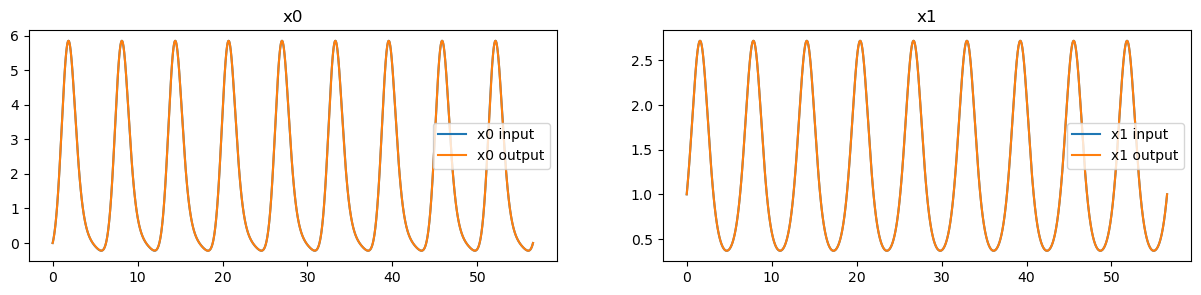

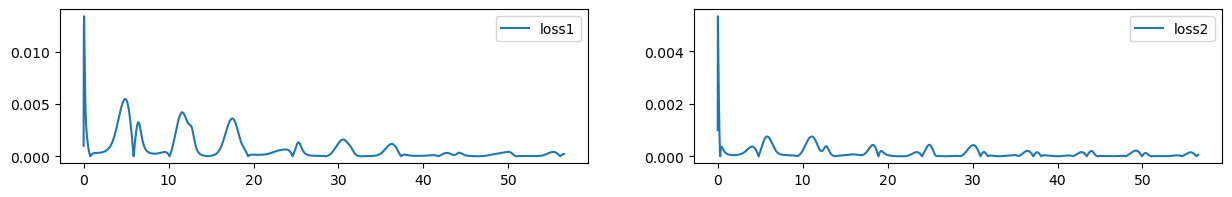

In [57]:
x = np.array(dnn.history_x)
loss = np.array(dnn.history_loss)

fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time, x_input[:,0,:], label=f"x0 input")
ax[0].plot(time, x[:,0,:], label=f"x0 output")
ax[0].set_title('x0')
ax[0].legend()
# ax[0].set_ylim([-6, 6])

ax[1].plot(time, x_input[:,1,:], label=f"x1 input")
ax[1].plot(time, x[:,1,:], label=f"x1 output")
ax[1].set_title('x1')
ax[1].legend()
# ax[1].set_ylim([-6, 3.3])
plt.show()


fig, ax = plt.subplots(ncols=2, figsize=(15, 2), sharex=True, sharey=False)
ax[0].plot(time[:-1], loss[:,0,:], label=f"loss1")
ax[0].legend()
ax[1].plot(time[:-1], loss[:,1,:], label=f"loss2")
ax[1].legend()
plt.show()



IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

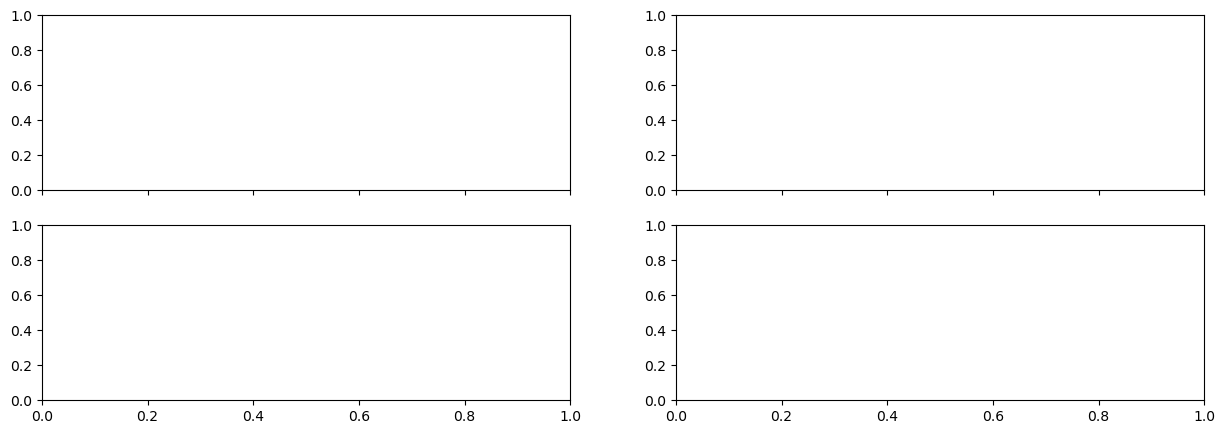

In [59]:
PRP = np.array(dnn.history_PRP)

fig, ax = plt.subplots(nrows=dnn._state_size, ncols=dnn._state_size, figsize=(15, 5), sharex=True, sharey=False)
for i in range(dnn._state_size):
    for j in range(dnn._state_size):
        ax[i, j].plot(time[:-1], PRP[:,i,j], label=f"{(i,j)}")
        ax[i, j].legend()
        # ax[i, j].set_ylim([-5, 5])
plt.show()

In [60]:
PRP

array([], dtype=float64)

In [61]:
np.random.seed(42)

# omega = np.linspace(0.1, 10, 6)
# omega[-1] = 0.99
# print(omega)
omega = np.array([1])

n_act = len(omega)

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e-2,
#     'k2': 1e-4,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_init': np.identity(2)*1e-5,
#     'r_init': np.identity(2)*1e11,
#     'p_init':  np.identity(2)*8,
#     'stop_time': 1*2*np.pi
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 9*1e3,
#     'k2': 1e4,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'q_fun': lambda t: np.identity(2)*0, # 10*(1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: np.identity(2)*1e6, # lambda t:  1e10*(1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': 0.17*time_end,
#     'qz': True,
#     }

################################################################################
## Somehow working params
# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e2,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'q_fun': lambda t: 1e-1 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1e-2 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': time_end,
#     'qz': True,
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e0,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_fun': lambda t: 1e-10 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.array([[10.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': 0.45*time_end,
#     'qz': True,
#     'use_x_hat': False
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e0,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_fun': lambda t: 1e-10 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.array([[10.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': time_end,
#     'qz': True,
#     'use_x_hat': False
#     }

dnn_params = {
    'state_size': 2,
    'u_size': 2,
    'k1': 1e0,
    'k2': 1e-1,
    'omega': omega,
    'wa_init': np.random.rand(2, 2*(2*n_act + 1)) * 1e-1,
    'wb_init': np.random.rand(2, 2*(2*n_act + 1)) * 1e-1,
    'q_fun': lambda t: 1e-5 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
    'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
    'p_init':  np.array([[20.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
    # 'stop_time': 1*2*np.pi,
    'stop_time': time_end,
    'qz': True,
    'use_x_hat': False,
    'omega_shift': 0
    }

In [62]:
dnn = DNN_P_const(**dnn_params)
# default_settings = {'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}
# np.seterr(**default_settings)
np.seterr(all='raise')


a_init = np.array([[2, 0],[0, 5]])*25
result = dnn.run(x=x_input, u=u_input, step_size=step, A_init=a_init)

print()
print(result)

100%|██████████| 56548/56548 [00:06<00:00, 8221.83it/s]


True


In [63]:
loss_norm = np.sum(np.linalg.norm(dnn.history_loss, axis=1))
loss_delta = np.sum(list(map(lambda el: np.transpose(el)@el, dnn.history_loss)))

print(f"Loss Norm:\t{loss_norm}")
print(f"Loss Delta:\t{loss_delta}")


Loss Norm:	44.27020235043777
Loss Delta:	0.125323076452353


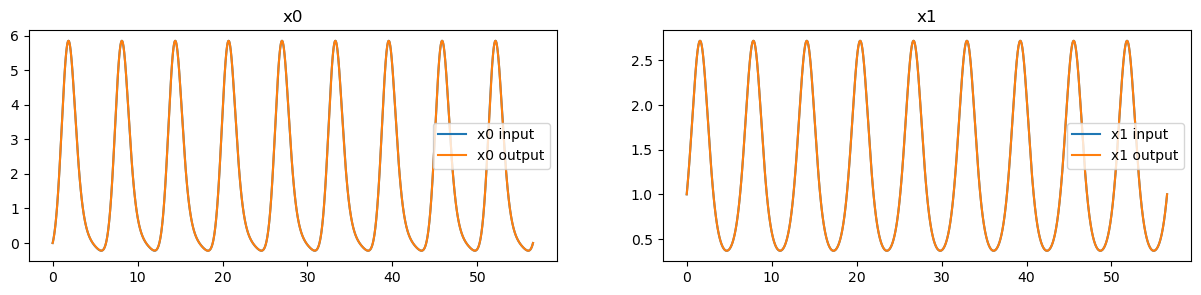

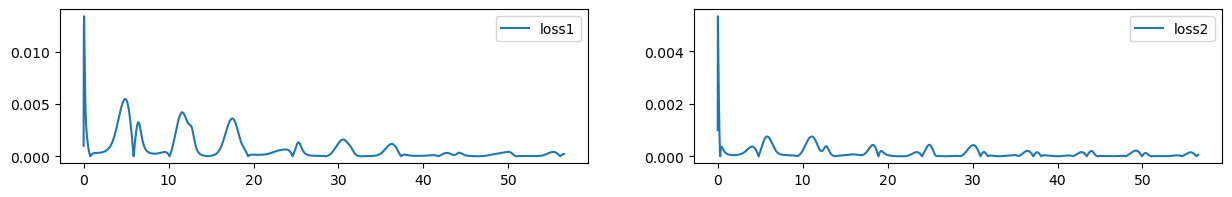

In [64]:
x = np.array(dnn.history_x)
loss = np.array(dnn.history_loss)

fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time, x_input[:,0,:], label=f"x0 input")
ax[0].plot(time, x[:,0,:], label=f"x0 output")
ax[0].set_title('x0')
ax[0].legend()
# ax[0].set_ylim([-6, 6])

ax[1].plot(time, x_input[:,1,:], label=f"x1 input")
ax[1].plot(time, x[:,1,:], label=f"x1 output")
ax[1].set_title('x1')
ax[1].legend()
# ax[1].set_ylim([-6, 3.3])
plt.show()


fig, ax = plt.subplots(ncols=2, figsize=(15, 2), sharex=True, sharey=False)
ax[0].plot(time[:-1], loss[:,0,:], label=f"loss1")
ax[0].legend()
ax[1].plot(time[:-1], loss[:,1,:], label=f"loss2")
ax[1].legend()
plt.show()



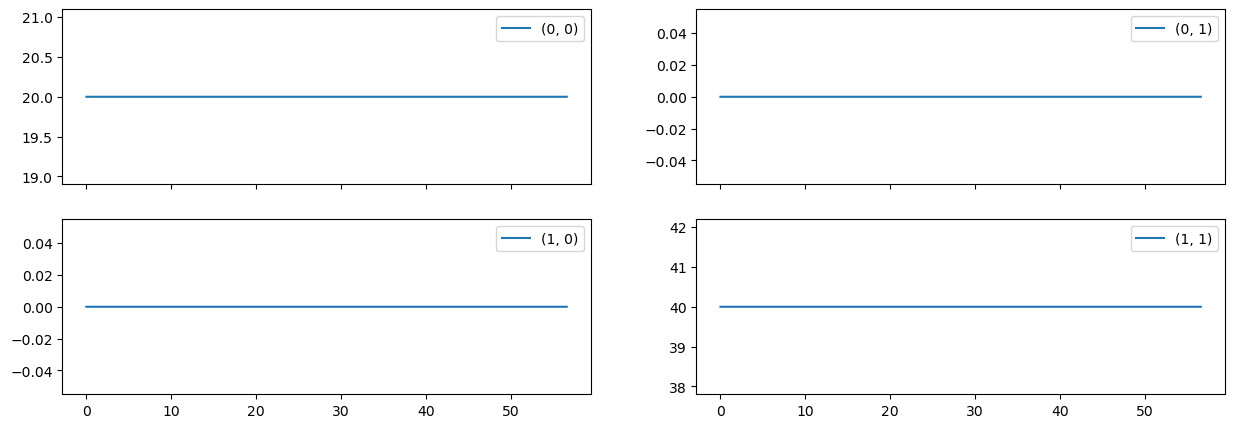

In [65]:
P = np.array(dnn.history_P)

fig, ax = plt.subplots(nrows=dnn._state_size, ncols=dnn._state_size, figsize=(15, 5), sharex=True, sharey=False)
for i in range(dnn._state_size):
    for j in range(dnn._state_size):
        ax[i, j].plot(time[:], P[:,i,j], label=f"{(i,j)}")
        ax[i, j].legend()
        # ax[i, j].set_ylim([-5, 5])
plt.show()

### Noisy input

In [66]:
noise = np.array([[0.05,0],[0,0.006]])@np.random.normal(0, 1, x_input.shape)

In [67]:
noise.shape

(56549, 2, 1)

In [68]:
noisy_input = x_input + noise

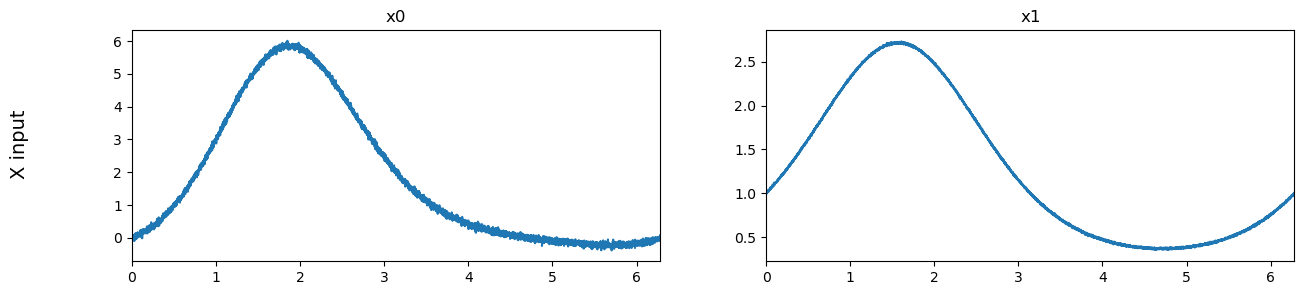

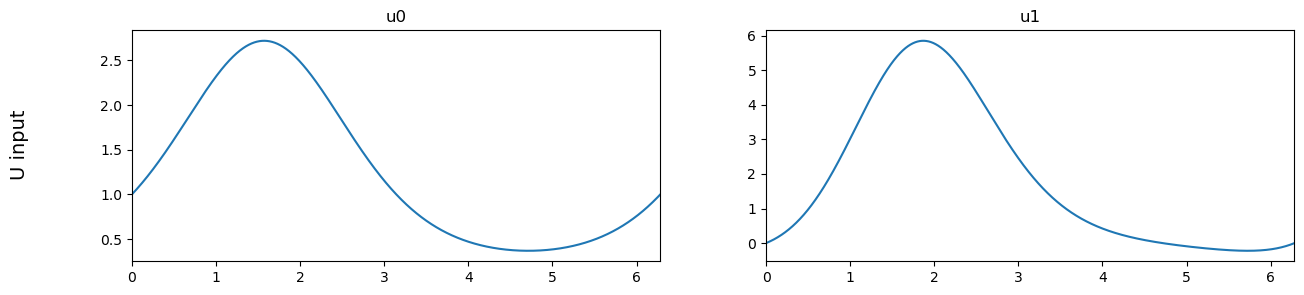

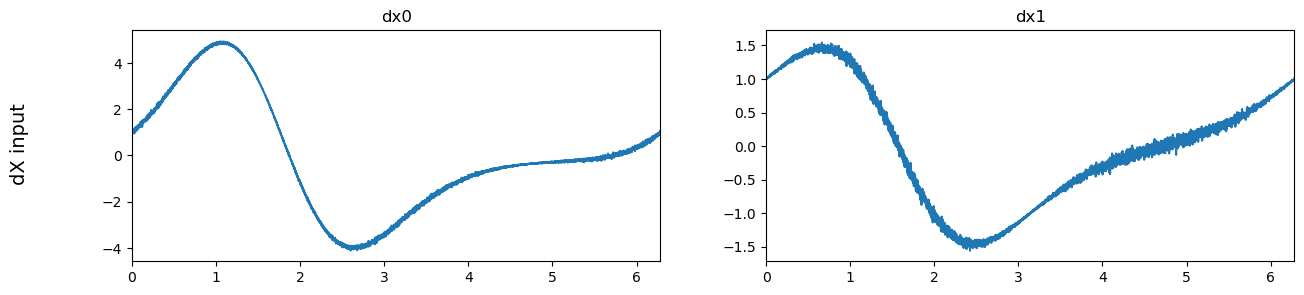

In [69]:
xlim = 2*np.pi

fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time, noisy_input[:,0,:])#, label=f"lr={res.learning_rate}")
ax[0].set_title('x0')
ax[0].set_xlim(0,xlim)
# ax[0].legend()
ax[1].plot(time, noisy_input[:,1,:])#, label=f"lr={res.learning_rate}")
ax[1].set_title('x1')
ax[1].set_xlim(0,xlim)
# ax[1].legend()
fig.text(0.05, 0.5, 'X input', ha='center', va='center', rotation='vertical', fontsize=14)
plt.show()

fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time, u_input[:,0,:])#, label=f"lr={res.learning_rate}")
ax[0].set_title('u0')
ax[1].set_xlim(0,xlim)
# ax[0].legend()
ax[1].plot(time, u_input[:,1,:])#, label=f"lr={res.learning_rate}")
ax[1].set_title('u1')
ax[1].set_xlim(0,xlim)
# ax[1].legend()
fig.text(0.05, 0.5, 'U input', ha='center', va='center', rotation='vertical', fontsize=14)
plt.show()


dx = np.array([AA(t)@(xx(t) + noise[i]) + BB(t)@uu(t) for i, t in enumerate(time)])

fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time, dx[:,0,:])#, label=f"lr={res.learning_rate}")
ax[0].set_title('dx0')
ax[0].set_xlim(0,xlim)
ax[1].plot(time, dx[:,1,:])#, label=f"lr={res.learning_rate}")
ax[1].set_title('dx1')
ax[1].set_xlim(0,xlim)
# ax[1].legend()
fig.text(0.05, 0.5, 'dX input', ha='center', va='center', rotation='vertical', fontsize=14)
plt.show()

In [70]:
# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e-2,
#     'k2': 1e-4,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_init': np.identity(2)*1e-5,
#     'r_init': np.identity(2)*1e11,
#     'p_init':  np.identity(2)*8,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': time_end,
#     'qz': False,
#     }

dnn_noise_params = dnn_params
# dnn_noise_params['k1'] = 1e-3
# dnn_noise_params['k2'] = 1e4

np.random.seed(42)


dnn = DNN_P_const(**dnn_noise_params)


result = dnn.run(x=noisy_input, u=u_input, step_size=step, A_init=a_init)

print()
print(result)

100%|██████████| 56548/56548 [00:06<00:00, 8865.23it/s]


True


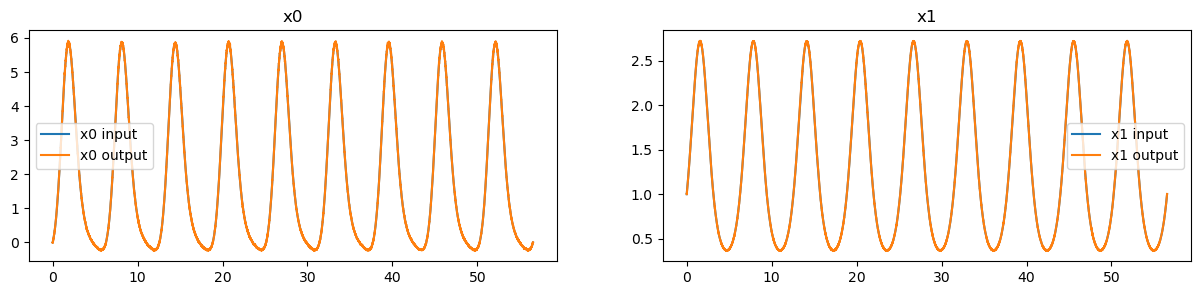

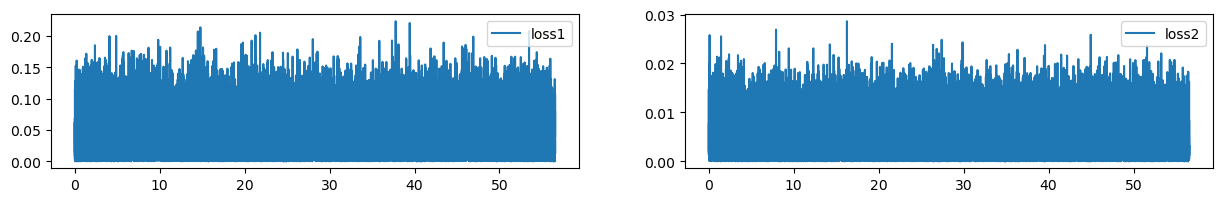

In [71]:
x = np.array(dnn.history_x)
loss = np.array(dnn.history_loss)

fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time, x_input[:,0,:], label=f"x0 input")
ax[0].plot(time, x[:,0,:], label=f"x0 output")
ax[0].set_title('x0')
ax[0].legend()
# ax[0].set_ylim([-2, 10])

ax[1].plot(time, x_input[:,1,:], label=f"x1 input")
ax[1].plot(time, x[:,1,:], label=f"x1 output")
ax[1].set_title('x1')
ax[1].legend()
# ax[1].set_ylim([-2, 2])
plt.show()


fig, ax = plt.subplots(ncols=2, figsize=(15, 2), sharex=True, sharey=False)
ax[0].plot(time[:-1], loss[:,0,:], label=f"loss1")
ax[0].legend()
ax[1].plot(time[:-1], loss[:,1,:], label=f"loss2")
ax[1].legend()
plt.show()

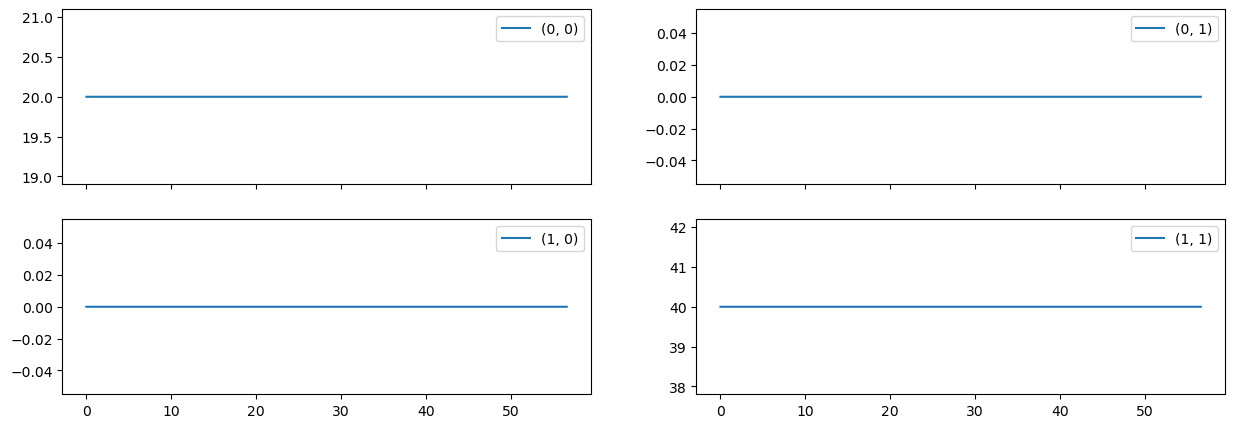

In [72]:
P = np.array(dnn.history_P)

fig, ax = plt.subplots(nrows=dnn._state_size, ncols=dnn._state_size, figsize=(15, 5), sharex=True, sharey=False)
for i in range(dnn._state_size):
    for j in range(dnn._state_size):
        ax[i, j].plot(time, P[:,i,j], label=f"{(i,j)}")
        ax[i, j].legend()
        # ax[i, j].set_ylim([-10, 10])
plt.show()

# Sigmoidal activation function

In [73]:
def sigmoid(y):
    return 1/(1 + np.exp(-y))

In [74]:
from tqdm import tqdm

class DNN_sigmoid:
    def __init__(self, state_size, u_size, k1, k2, omega, wa_init, wb_init, q_fun, r_fun, p_init, stop_time, qz=False, use_x_hat=False, omega_shift=0):
        self._state_size = state_size
        self._u_size = u_size 
        self.n_act = len(omega)
        self._one = np.array([1])
        self.omega_shift = omega_shift

        self._qz = qz
        self.use_x_hat = use_x_hat

        self.k1 = k1
        self.k2 = k2

        self.omega = omega

        self.Wa_init = wa_init
        self.Wb_init = wb_init
        
        self.Q_fun = q_fun
        self.R_fun = r_fun
        self.P_init = p_init

        self.stop_time = stop_time
        
        self._pd_check = []
        self.history_x = []
        self.history_Wa = []
        self.history_Wb = []
        self.history_P = []
        self.history_Wa_upsilon = []
        self.history_Wb_upsilon = []
        self.history_dx_dt = []
        self.history_dP_dt = []
        self.history_PRP = []
        self.history_Q = []

    def get_upsilon(self, t):
        omega = self.omega * t
        return self.omega_shift + np.reshape(np.concatenate((self._one, sigmoid(omega), sigmoid(omega))), (self.n_act * 2 + 1, 1))

    @staticmethod
    def fit_upsilon(upsilon, n_shape):
        return np.kron(upsilon, np.identity(n_shape))

    def law_Wa(self, P, delta, upsilon_a, x_hat):
        res = None
        res1 = None
        try:
            res = (1/self.k1)
            res = res*P
            res = res@delta
            res1 = np.transpose(upsilon_a@x_hat)
            res = res@res1
        except Exception as e:
            pprint.pprint(e)

            print('P')
            pprint.pprint(P)
            print('delta')
            pprint.pprint(delta)
            print('upsilon_a@x_hat')
            pprint.pprint(res1)

            raise e
        return res

        # return (1/self.k1)*P@delta@np.transpose(upsilon_a@x_hat)

    def law_Wb(self, P, delta, upsilon_b, u):
        res = None
        res1 = None
        try:
            res = (1/self.k2)
            res = res*P
            res = res@delta
            res1 = np.transpose(upsilon_b@u)
            res = res@res1
        except Exception as e:
            pprint.pprint(e)

            print('P')
            pprint.pprint(P)
            print('delta')
            pprint.pprint(delta)
            print('upsilon_b@u')
            pprint.pprint(res1)

            raise e
        return res
        # return (1/self.k2)*P@delta@np.transpose(upsilon_b@u)
    
    def law_PRP(self, P, Wb, upsilon_b, tk):
        Wb_upsilon = None
        BRB = None
        try:
            Wb_upsilon = Wb@upsilon_b
            BRB = Wb_upsilon@self.R_fun(tk)@Wb_upsilon.T
            res = P@BRB@P
        except Exception as e:
            pprint.pprint(e)
            print('B@R^-1@B.T')
            pprint.pprint(BRB)
            print('P')
            pprint.pprint(P)
            raise e

        return res
    
    @staticmethod
    def is_pos_def(A):
        if np.allclose(A, A.T):
            try:
                np.linalg.cholesky(A)
                return True
            except np.linalg.LinAlgError:
                return False
        else:
            return False

    def run(self, x, u, step_size, A_init=np.zeros):
        # Initialize vector
        self.history_x = []
        # cur_x = np.zeros(shape=(self._state_size, 1))
        cur_x = np.array([0.0, 1.0]).reshape((self._state_size, 1))
        self.history_x.append(cur_x.copy())
        
        # Identification error
        delta = np.zeros(x.shape)
        
        self.history_Wa = []
        cur_Wa = self.Wa_init.copy()
        self.history_Wa.append(self.Wa_init.copy())
        
        self.history_Wb = []
        cur_Wb = self.Wb_init.copy()
        self.history_Wb.append(self.Wb_init.copy())
        
        cur_P = self.P_init.copy()
        self.history_P = []
        self.history_P.append(cur_P.copy())

        self.history_loss = []

        self.history_upsilon = []
        
        for i in tqdm(range(1, len(x))):
            cur_t = i * step_size

            delta_x = x[i] - cur_x
            # print(u[i].shape)
            # print(x[i].shape)
            # print(delta_x.shape)
            self.history_loss.append(np.abs(delta_x))

            upsilon_i = self.get_upsilon((i-1)*step_size)
            upsilon_a = self.fit_upsilon(upsilon_i, self._state_size)
            upsilon_b = self.fit_upsilon(upsilon_i, self._u_size)
            
            self.history_upsilon.append(upsilon_i.copy())

            # print(upsilon_i.shape)
            # print(upsilon_a.shape)
            # print(upsilon_b.shape)

            PRP = np.zeros_like(self.P_init)
            dP_dt = np.zeros_like(self.P_init)

            if cur_t <= self.stop_time:
                # PRP = cur_P@cur_Wb@upsilon_b@self.R_fun((i-1)*step_size)@(cur_Wb@upsilon_b).T@cur_P
                PRP = self.law_PRP(P=cur_P, Wb=cur_Wb, upsilon_b=upsilon_b, tk=(i-1)*step_size)

                if self._qz:
                    cur_Q = PRP + self.Q_fun((i-1)*step_size)
                else:
                    cur_Q = self.Q_fun((i-1)*step_size)

                dP_dt = -cur_P@cur_Wa@upsilon_a - (cur_Wa@upsilon_a).T@cur_P - cur_Q + PRP
                        
            self.history_Q.append(cur_Q.copy())
            self.history_PRP.append(PRP.copy())
            self.history_dP_dt.append(dP_dt.copy())

            cur_P += step_size*dP_dt
            
            check_pd = self.is_pos_def(cur_P)
            if not check_pd:
                cur_P -= 2*step_size*dP_dt
              
            self.history_P.append(cur_P.copy())
            
            self._pd_check.append(self.is_pos_def(cur_P))
            # print(cur_P.shape)

            if cur_t <= self.stop_time:
                if self.use_x_hat:
                    dWa_dt = self.law_Wa(P=cur_P, delta=delta_x, upsilon_a=upsilon_a, x_hat=cur_x)
                else:
                    dWa_dt = self.law_Wa(P=cur_P, delta=delta_x, upsilon_a=upsilon_a, x_hat=x[i])

                dWb_dt = self.law_Wb(P=cur_P, delta=delta_x, upsilon_b=upsilon_b, u=u[i])
            else:
                dWa_dt = np.zeros_like(self.Wa_init)
                dWb_dt = np.zeros_like(self.Wb_init)

            cur_Wa += step_size*dWa_dt
            self.history_Wa.append(cur_Wa.copy())
            
            cur_Wb += step_size*dWb_dt
            self.history_Wb.append(cur_Wb.copy())
            
            Wa_upsilon = cur_Wa@upsilon_a
            Wb_upsilon = cur_Wb@upsilon_b
            self.history_Wa_upsilon.append(Wa_upsilon.copy())
            self.history_Wb_upsilon.append(Wb_upsilon.copy())
            
            dx_dt = (Wa_upsilon)@cur_x + Wb_upsilon@u[i] + A_init@delta_x
            # print(((Wa_upsilon)@x[i] + Wb_upsilon@u[i]).shape)
            # print(((A_init + Wa_upsilon)@x[i] + Wb_upsilon@u[i]).shape)
            self.history_dx_dt.append(dx_dt.copy())

            cur_x += step_size * dx_dt
            self.history_x.append(cur_x.copy())
        
        
        return np.all(self._pd_check)

In [75]:
time_end = 9*2*np.pi
step = 0.001
time = np.arange(0,time_end,step)
x_input = xx(time)
u_input = uu(time)
xlim = 2*np.pi
# xlim = time_end

dx = np.array([AA(t)@xx(t) + BB(t)@uu(t) for t in time])

A = np.array([AA(t) for t in time])
B = np.array([BB(t) for t in time])

In [76]:
np.random.seed(42)

# omega = np.linspace(0.1, 10, 6)
# omega[-1] = 0.99
# print(omega)
omega = np.array([1])

n_act = len(omega)

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e-2,
#     'k2': 1e-4,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_init': np.identity(2)*1e-5,
#     'r_init': np.identity(2)*1e11,
#     'p_init':  np.identity(2)*8,
#     'stop_time': 1*2*np.pi
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 9*1e3,
#     'k2': 1e4,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'q_fun': lambda t: np.identity(2)*0, # 10*(1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: np.identity(2)*1e6, # lambda t:  1e10*(1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': 0.17*time_end,
#     'qz': True,
#     }

################################################################################
## Somehow working params
# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e2,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'q_fun': lambda t: 1e-1 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1e-2 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': time_end,
#     'qz': True,
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e0,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_fun': lambda t: 1e-10 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.array([[10.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': 0.45*time_end,
#     'qz': True,
#     'use_x_hat': False
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e0,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_fun': lambda t: 1e-10 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.array([[10.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': time_end,
#     'qz': True,
#     'use_x_hat': False
#     }

dnn_params = {
    'state_size': 2,
    'u_size': 2,
    'k1': 1e0,
    'k2': 1e-1,
    'omega': omega,
    'wa_init': np.random.rand(2, 2*(2*n_act + 1)) * 1e-1,
    'wb_init': np.random.rand(2, 2*(2*n_act + 1)) * 1e-1,
    'q_fun': lambda t: 1e-5 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
    'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
    'p_init':  np.array([[20.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
    # 'stop_time': 1*2*np.pi,
    'stop_time': time_end,
    'qz': True,
    'use_x_hat': False,
    'omega_shift': 0
    }

In [77]:
dnn = DNN_sigmoid(**dnn_params)
# default_settings = {'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}
# np.seterr(**default_settings)
np.seterr(all='raise')


a_init = np.array([[2, 0],[0, 5]])*25
result = dnn.run(x=x_input, u=u_input, step_size=step, A_init=a_init)

print()
print(result)

 35%|███▍      | 19622/56548 [00:03<00:07, 5240.02it/s]

FloatingPointError('overflow encountered in matmul')
B@R^-1@B.T
None
P
array([[-1.51133639e+09, -1.85461919e+09],
       [-1.85461919e+09, -2.26659155e+09]])


FloatingPointError: overflow encountered in matmul

In [78]:
loss_norm = np.sum(np.linalg.norm(dnn.history_loss, axis=1))
loss_delta = np.sum(list(map(lambda el: np.transpose(el)@el, dnn.history_loss)))

print(f"Loss Norm:\t{loss_norm}")
print(f"Loss Delta:\t{loss_delta}")


FloatingPointError: overflow encountered in multiply

(56549,) (56549, 2, 1) (19623, 2, 1) (19623, 2, 1)


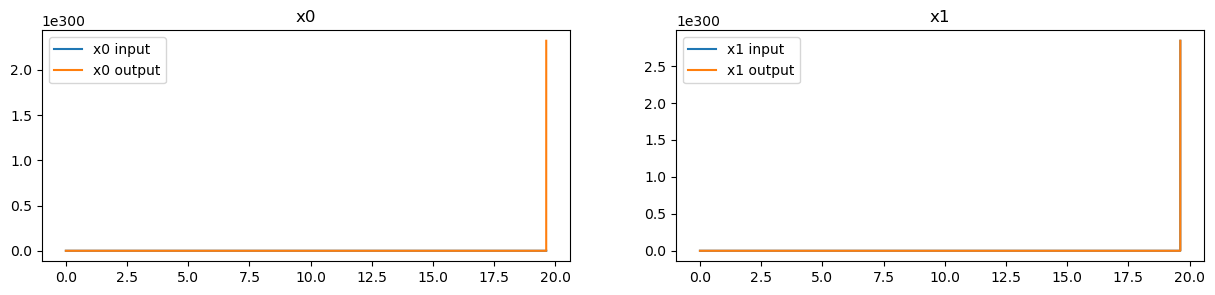

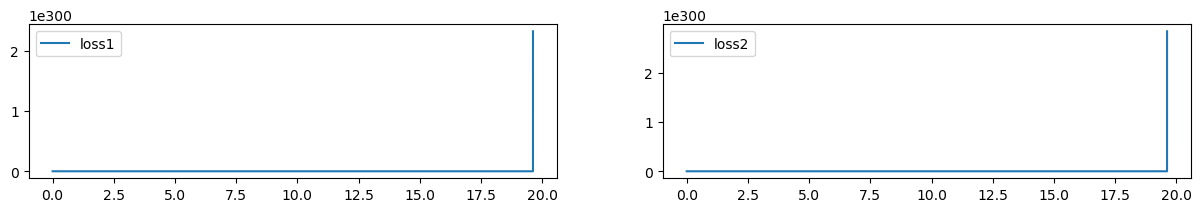

In [79]:
x = np.array(dnn.history_x)
loss = np.array(dnn.history_loss)

print(time.shape, x_input.shape, x.shape, loss.shape)

fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time[:x.shape[0]], x_input[:x.shape[0],0,:], label=f"x0 input")
ax[0].plot(time[:x.shape[0]], x[:,0,:], label=f"x0 output")
ax[0].set_title('x0')
ax[0].legend()
# ax[0].set_ylim([-6, 6])

ax[1].plot(time[:x.shape[0]], x[:x.shape[0],1,:], label=f"x1 input")
ax[1].plot(time[:x.shape[0]], x[:,1,:], label=f"x1 output")
ax[1].set_title('x1')
ax[1].legend()
# ax[1].set_ylim([-6, 3.3])
plt.show()


fig, ax = plt.subplots(ncols=2, figsize=(15, 2), sharex=True, sharey=False)
ax[0].plot(time[:x.shape[0]], loss[:,0,:], label=f"loss1")
ax[0].legend()
ax[1].plot(time[:x.shape[0]], loss[:,1,:], label=f"loss2")
ax[1].legend()
plt.show()



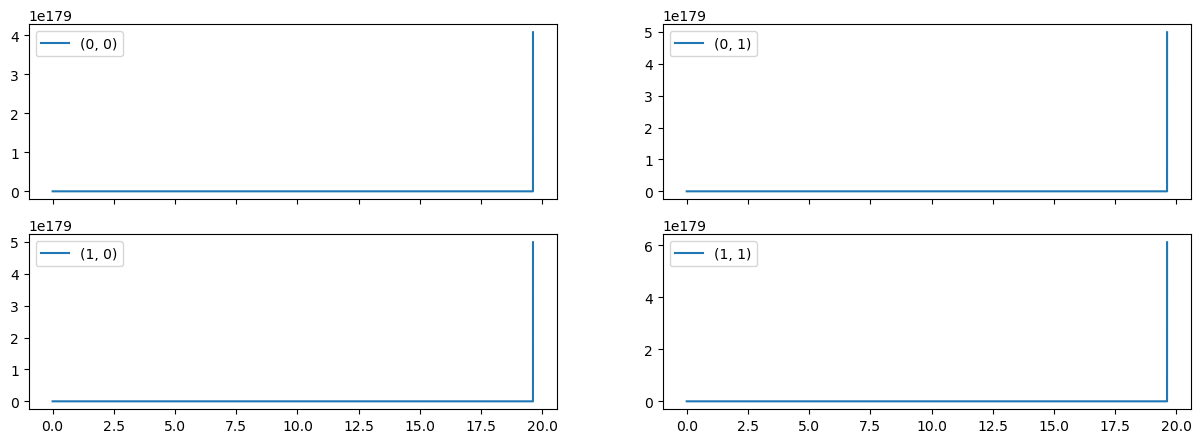

In [80]:
PRP = np.array(dnn.history_PRP)

fig, ax = plt.subplots(nrows=dnn._state_size, ncols=dnn._state_size, figsize=(15, 5), sharex=True, sharey=False)
for i in range(dnn._state_size):
    for j in range(dnn._state_size):
        ax[i, j].plot(time[:PRP.shape[0]], PRP[:,i,j], label=f"{(i,j)}")
        ax[i, j].legend()
        # ax[i, j].set_ylim([-5, 5])
plt.show()

In [81]:
time_end = 1.5*2*np.pi
step = 0.001
time = np.arange(0,time_end,step)
x_input = xx(time)
u_input = uu(time)
xlim = 2*np.pi
# xlim = time_end

dx = np.array([AA(t)@xx(t) + BB(t)@uu(t) for t in time])

A = np.array([AA(t) for t in time])
B = np.array([BB(t) for t in time])

In [82]:
np.random.seed(42)

# omega = np.linspace(0.1, 10, 6)
# omega[-1] = 0.99
# print(omega)
omega = np.array([1])

n_act = len(omega)

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e-2,
#     'k2': 1e-4,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_init': np.identity(2)*1e-5,
#     'r_init': np.identity(2)*1e11,
#     'p_init':  np.identity(2)*8,
#     'stop_time': 1*2*np.pi
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 9*1e3,
#     'k2': 1e4,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'q_fun': lambda t: np.identity(2)*0, # 10*(1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: np.identity(2)*1e6, # lambda t:  1e10*(1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': 0.17*time_end,
#     'qz': True,
#     }

################################################################################
## Somehow working params
# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e2,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'q_fun': lambda t: 1e-1 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1e-2 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': time_end,
#     'qz': True,
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e0,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_fun': lambda t: 1e-10 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.array([[10.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': 0.45*time_end,
#     'qz': True,
#     'use_x_hat': False
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e0,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_fun': lambda t: 1e-10 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.array([[10.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': time_end,
#     'qz': True,
#     'use_x_hat': False
#     }

dnn_params = {
    'state_size': 2,
    'u_size': 2,
    'k1': 1e0,
    'k2': 1e-1,
    'omega': omega,
    'wa_init': np.random.rand(2, 2*(2*n_act + 1)) * 1e-1,
    'wb_init': np.random.rand(2, 2*(2*n_act + 1)) * 1e-1,
    'q_fun': lambda t: 1e-5 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
    'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
    'p_init':  np.array([[20.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
    # 'stop_time': 1*2*np.pi,
    'stop_time': time_end,
    'qz': True,
    'use_x_hat': False,
    'omega_shift': 0
    }

In [83]:
dnn = DNN_sigmoid(**dnn_params)
# default_settings = {'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}
# np.seterr(**default_settings)
np.seterr(all='raise')


a_init = np.array([[2, 0],[0, 5]])*25
result = dnn.run(x=x_input, u=u_input, step_size=step, A_init=a_init)

print()
print(result)

100%|██████████| 9424/9424 [00:01<00:00, 5194.81it/s]


True


In [84]:
loss_norm = np.sum(np.linalg.norm(dnn.history_loss, axis=1))
loss_delta = np.sum(list(map(lambda el: np.transpose(el)@el, dnn.history_loss)))

print(f"Loss Norm:\t{loss_norm}")
print(f"Loss Delta:\t{loss_delta}")


Loss Norm:	66.54896529174381
Loss Delta:	0.9414154976626684


(9425,) (9425, 2, 1) (9425, 2, 1) (9424, 2, 1)


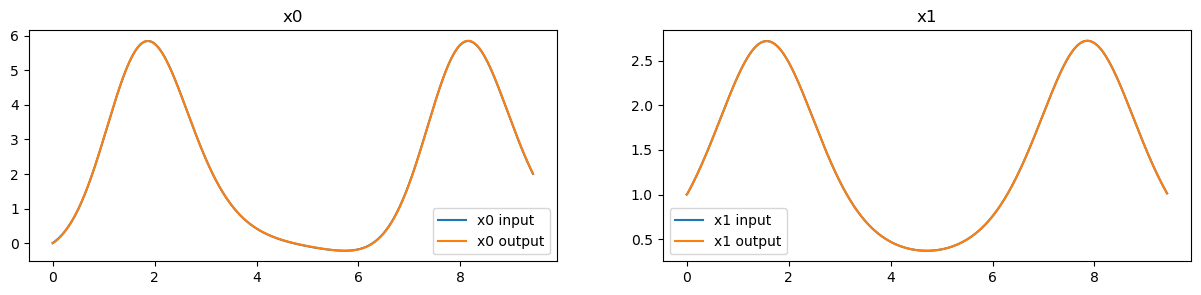

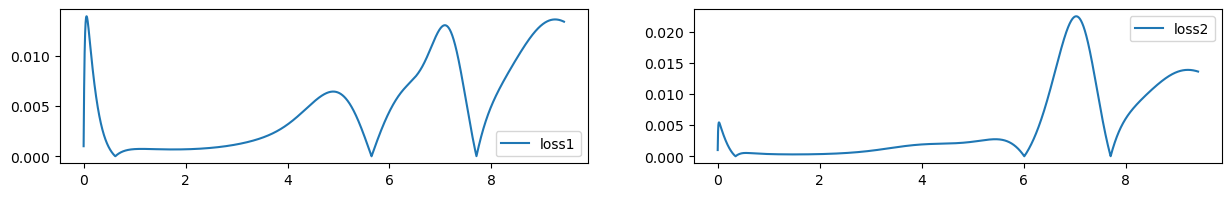

In [85]:
x = np.array(dnn.history_x)
loss = np.array(dnn.history_loss)

print(time.shape, x_input.shape, x.shape, loss.shape)

fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time[:x.shape[0]], x_input[:x.shape[0],0,:], label=f"x0 input")
ax[0].plot(time[:x.shape[0]], x[:,0,:], label=f"x0 output")
ax[0].set_title('x0')
ax[0].legend()
# ax[0].set_ylim([-6, 6])

ax[1].plot(time[:x.shape[0]], x[:x.shape[0],1,:], label=f"x1 input")
ax[1].plot(time[:x.shape[0]], x[:,1,:], label=f"x1 output")
ax[1].set_title('x1')
ax[1].legend()
# ax[1].set_ylim([-6, 3.3])
plt.show()


fig, ax = plt.subplots(ncols=2, figsize=(15, 2), sharex=True, sharey=False)
ax[0].plot(time[:x.shape[0]-1], loss[:,0,:], label=f"loss1")
ax[0].legend()
ax[1].plot(time[:x.shape[0]-1], loss[:,1,:], label=f"loss2")
ax[1].legend()
plt.show()



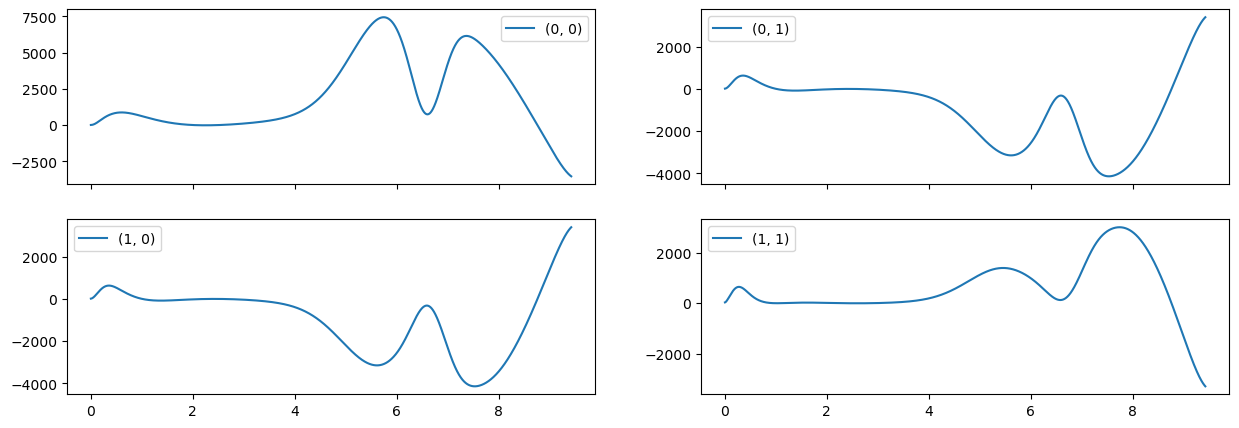

In [86]:
PRP = np.array(dnn.history_PRP)

fig, ax = plt.subplots(nrows=dnn._state_size, ncols=dnn._state_size, figsize=(15, 5), sharex=True, sharey=False)
for i in range(dnn._state_size):
    for j in range(dnn._state_size):
        ax[i, j].plot(time[:PRP.shape[0]], PRP[:,i,j], label=f"{(i,j)}")
        ax[i, j].legend()
        # ax[i, j].set_ylim([-5, 5])
plt.show()

In [87]:
time_end = 3*2*np.pi
step = 0.001
time = np.arange(0,time_end,step)
x_input = xx(time)
u_input = uu(time)
xlim = 2*np.pi
# xlim = time_end

dx = np.array([AA(t)@xx(t) + BB(t)@uu(t) for t in time])

A = np.array([AA(t) for t in time])
B = np.array([BB(t) for t in time])

In [88]:
np.random.seed(42)

# omega = np.linspace(0.1, 10, 6)
# omega[-1] = 0.99
# print(omega)
omega = np.array([1])

n_act = len(omega)

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e-2,
#     'k2': 1e-4,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_init': np.identity(2)*1e-5,
#     'r_init': np.identity(2)*1e11,
#     'p_init':  np.identity(2)*8,
#     'stop_time': 1*2*np.pi
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 9*1e3,
#     'k2': 1e4,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'q_fun': lambda t: np.identity(2)*0, # 10*(1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: np.identity(2)*1e6, # lambda t:  1e10*(1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': 0.17*time_end,
#     'qz': True,
#     }

################################################################################
## Somehow working params
# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e2,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'q_fun': lambda t: 1e-1 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1e-2 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': time_end,
#     'qz': True,
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e0,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_fun': lambda t: 1e-10 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.array([[10.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': 0.45*time_end,
#     'qz': True,
#     'use_x_hat': False
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e0,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_fun': lambda t: 1e-10 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.array([[10.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': time_end,
#     'qz': True,
#     'use_x_hat': False
#     }

dnn_params = {
    'state_size': 2,
    'u_size': 2,
    'k1': 1e0,
    'k2': 1e-1,
    'omega': omega,
    'wa_init': np.random.rand(2, 2*(2*n_act + 1)) * 1e-1,
    'wb_init': np.random.rand(2, 2*(2*n_act + 1)) * 1e-1,
    'q_fun': lambda t: 1e-5 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
    'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
    'p_init':  np.array([[20.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
    # 'stop_time': 1*2*np.pi,
    'stop_time': time_end,
    'qz': True,
    'use_x_hat': False,
    'omega_shift': 0
    }

In [89]:
dnn = DNN_sigmoid(**dnn_params)
# default_settings = {'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}
# np.seterr(**default_settings)
np.seterr(all='raise')


a_init = np.array([[2, 0],[0, 5]])*25
result = dnn.run(x=x_input, u=u_input, step_size=step, A_init=a_init)

print()
print(result)

100%|██████████| 18849/18849 [00:03<00:00, 5098.25it/s]


False


In [90]:
loss_norm = np.sum(np.linalg.norm(dnn.history_loss, axis=1))
loss_delta = np.sum(list(map(lambda el: np.transpose(el)@el, dnn.history_loss)))

print(f"Loss Norm:\t{loss_norm}")
print(f"Loss Delta:\t{loss_delta}")


Loss Norm:	1024.0994917436608
Loss Delta:	288.85470185551736


(18850,) (18850, 2, 1) (18850, 2, 1) (18849, 2, 1)


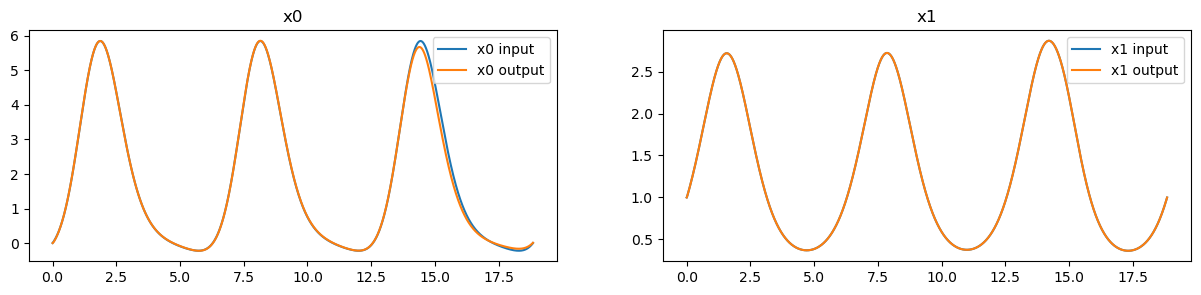

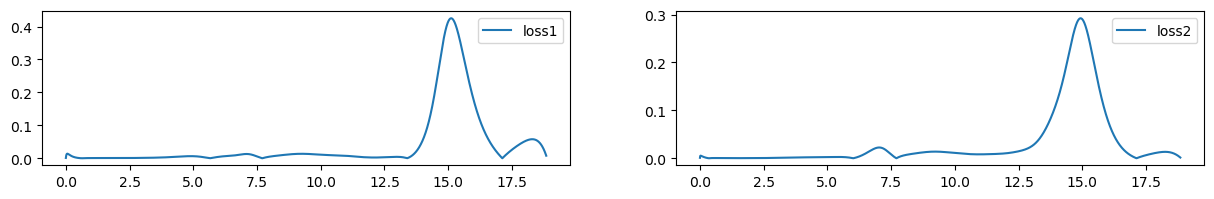

In [91]:
x = np.array(dnn.history_x)
loss = np.array(dnn.history_loss)

print(time.shape, x_input.shape, x.shape, loss.shape)

fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time[:x.shape[0]], x_input[:x.shape[0],0,:], label=f"x0 input")
ax[0].plot(time[:x.shape[0]], x[:,0,:], label=f"x0 output")
ax[0].set_title('x0')
ax[0].legend()
# ax[0].set_ylim([-6, 6])

ax[1].plot(time[:x.shape[0]], x[:x.shape[0],1,:], label=f"x1 input")
ax[1].plot(time[:x.shape[0]], x[:,1,:], label=f"x1 output")
ax[1].set_title('x1')
ax[1].legend()
# ax[1].set_ylim([-6, 3.3])
plt.show()


fig, ax = plt.subplots(ncols=2, figsize=(15, 2), sharex=True, sharey=False)
ax[0].plot(time[:x.shape[0]-1], loss[:,0,:], label=f"loss1")
ax[0].legend()
ax[1].plot(time[:x.shape[0]-1], loss[:,1,:], label=f"loss2")
ax[1].legend()
plt.show()



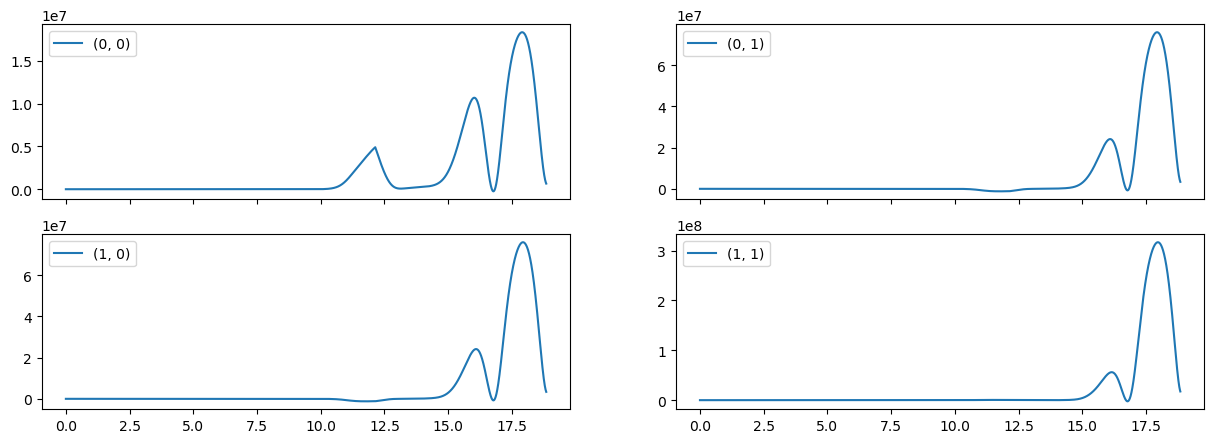

In [92]:
PRP = np.array(dnn.history_PRP)

fig, ax = plt.subplots(nrows=dnn._state_size, ncols=dnn._state_size, figsize=(15, 5), sharex=True, sharey=False)
for i in range(dnn._state_size):
    for j in range(dnn._state_size):
        ax[i, j].plot(time[:PRP.shape[0]], PRP[:,i,j], label=f"{(i,j)}")
        ax[i, j].legend()
        # ax[i, j].set_ylim([-5, 5])
plt.show()

# Stop learning

In [3]:
def AA(t):
    res = np.array([[np.cos(t), np.sin(t)],
                    [-np.sin(t), np.cos(t)]])
    return np.array(res)

def BB(t):
    return np.array([[np.cos(t), 0],
                    [0, np.sin(t)]])
def uu(t):
    return np.array([[np.exp(np.sin(t)), np.exp(np.sin(t)) * (1 - np.cos(t) + np.sin(t))]]).T

def xx(t):
    return np.array([[np.exp(np.sin(t)) * (1 - np.cos(t) + np.sin(t)), np.exp(np.sin(t))]]).T


In [ ]:
class PeriodicDNN:
    def __init__(self, state_size, u_size, k1, k2, omega, wa_init, wb_init, q_fun, r_fun, p_init, stop_time, qz=False, use_x_hat=False, omega_shift=0):
        self._state_size = state_size
        self._u_size = u_size 
        self.n_act = len(omega)
        self._one = np.array([1])
        self.omega_shift = omega_shift

        self._qz = qz
        self.use_x_hat = use_x_hat

        self.k1 = k1
        self.k2 = k2

        self.omega = omega

        self.Wa_init = wa_init
        self.Wb_init = wb_init
        
        self.Q_fun = q_fun
        self.R_fun = r_fun
        self.P_init = p_init

        self.stop_time = stop_time
        
        self._pd_check = []
        self.history_x = []
        self.history_Wa = []
        self.history_Wb = []
        self.history_P = []
        self.history_Wa_upsilon = []
        self.history_Wb_upsilon = []
        self.history_dx_dt = []
        self.history_dP_dt = []
        self.history_PRP = []
        self.history_Q = []

    def get_upsilon(self, t):
        omega = self.omega * t
        return self.omega_shift + np.reshape(np.concatenate((self._one, np.sin(omega), np.cos(omega))), (self.n_act * 2 + 1, 1))

    @staticmethod
    def fit_upsilon(upsilon, n_shape):
        return np.kron(upsilon, np.identity(n_shape))

    def law_Wa(self, P, delta, upsilon_a, x_hat):
        res = None
        res1 = None
        try:
            res = (1/self.k1)
            res = res*P
            res = res@delta
            res1 = np.transpose(upsilon_a@x_hat)
            res = res@res1
        except Exception as e:
            pprint.pprint(e)

            print('P')
            pprint.pprint(P)
            print('delta')
            pprint.pprint(delta)
            print('upsilon_a@x_hat')
            pprint.pprint(res1)

            raise e
        return res

        # return (1/self.k1)*P@delta@np.transpose(upsilon_a@x_hat)

    def law_Wb(self, P, delta, upsilon_b, u):
        res = None
        res1 = None
        try:
            res = (1/self.k2)
            res = res*P
            res = res@delta
            res1 = np.transpose(upsilon_b@u)
            res = res@res1
        except Exception as e:
            pprint.pprint(e)

            print('P')
            pprint.pprint(P)
            print('delta')
            pprint.pprint(delta)
            print('upsilon_b@u')
            pprint.pprint(res1)

            raise e
        return res
        # return (1/self.k2)*P@delta@np.transpose(upsilon_b@u)
    
    def law_PRP(self, P, Wb, upsilon_b, tk):
        Wb_upsilon = None
        BRB = None
        try:
            Wb_upsilon = Wb@upsilon_b
            BRB = Wb_upsilon@self.R_fun(tk)@Wb_upsilon.T
            res = P@BRB@P
        except Exception as e:
            pprint.pprint(e)
            print('B@R^-1@B.T')
            pprint.pprint(BRB)
            print('P')
            pprint.pprint(P)
            raise e

        return res
    
    @staticmethod
    def is_pos_def(A):
        if np.allclose(A, A.T):
            try:
                np.linalg.cholesky(A)
                return True
            except np.linalg.LinAlgError:
                return False
        else:
            return False

    def run(self, xx, uu, step_size, A_init=np.zeros):  # xx, uu - functions
        xx_history = []
    
        # Initialize vector
        self.history_x = []
        # cur_x = np.zeros(shape=(self._state_size, 1))
        cur_x = np.array([0.0, 1.0]).reshape((self._state_size, 1))
        self.history_x.append(cur_x.copy())
        
        # Identification error
        delta = np.zeros(x.shape)
        
        self.history_Wa = []
        cur_Wa = self.Wa_init.copy()
        self.history_Wa.append(self.Wa_init.copy())
        
        self.history_Wb = []
        cur_Wb = self.Wb_init.copy()
        self.history_Wb.append(self.Wb_init.copy())
        
        cur_P = self.P_init.copy()
        self.history_P = []
        self.history_P.append(cur_P.copy())

        self.history_loss = []

        self.history_upsilon = []
        
        for i in tqdm(range(1, len(x))):
            cur_t = i * step_size

            #delta_x = x[i] - cur_x
            delta = xx(cur_t) - cur_x
            xx_history.append(xx(cur_t))
            
            # print(u[i].shape)
            # print(x[i].shape)
            # print(delta_x.shape)
            self.history_loss.append(np.abs(delta_x))

            upsilon_i = self.get_upsilon((i-1)*step_size)
            upsilon_a = self.fit_upsilon(upsilon_i, self._state_size)
            upsilon_b = self.fit_upsilon(upsilon_i, self._u_size)
            
            self.history_upsilon.append(upsilon_i.copy())

            # print(upsilon_i.shape)
            # print(upsilon_a.shape)
            # print(upsilon_b.shape)

            PRP = np.zeros_like(self.P_init)
            dP_dt = np.zeros_like(self.P_init)

            if cur_t <= self.stop_time:
                # PRP = cur_P@cur_Wb@upsilon_b@self.R_fun((i-1)*step_size)@(cur_Wb@upsilon_b).T@cur_P
                PRP = self.law_PRP(P=cur_P, Wb=cur_Wb, upsilon_b=upsilon_b, tk=(i-1)*step_size)

                if self._qz:
                    cur_Q = PRP + self.Q_fun((i-1)*step_size)
                else:
                    cur_Q = self.Q_fun((i-1)*step_size)

                dP_dt = -cur_P@cur_Wa@upsilon_a - (cur_Wa@upsilon_a).T@cur_P - cur_Q + PRP
                        
            self.history_Q.append(cur_Q.copy())
            self.history_PRP.append(PRP.copy())
            self.history_dP_dt.append(dP_dt.copy())

            cur_P += step_size*dP_dt
            
            check_pd = self.is_pos_def(cur_P)
            if not check_pd:
                cur_P -= 2*step_size*dP_dt
              
            self.history_P.append(cur_P.copy())
            
            self._pd_check.append(self.is_pos_def(cur_P))
            # print(cur_P.shape)

            if cur_t <= self.stop_time:
                if self.use_x_hat:
                    dWa_dt = self.law_Wa(P=cur_P, delta=delta_x, upsilon_a=upsilon_a, x_hat=cur_x)
                else:
                    dWa_dt = self.law_Wa(P=cur_P, delta=delta_x, upsilon_a=upsilon_a, x_hat=x[i])

                dWb_dt = self.law_Wb(P=cur_P, delta=delta_x, upsilon_b=upsilon_b, u=u[i])
            else:
                dWa_dt = np.zeros_like(self.Wa_init)     # !!!!!!?????
                dWb_dt = np.zeros_like(self.Wb_init)     # !!!!!!?????

            cur_Wa += step_size*dWa_dt
            self.history_Wa.append(cur_Wa.copy())
            
            cur_Wb += step_size*dWb_dt
            self.history_Wb.append(cur_Wb.copy())
            
            Wa_upsilon = cur_Wa@upsilon_a
            Wb_upsilon = cur_Wb@upsilon_b
            self.history_Wa_upsilon.append(Wa_upsilon.copy())
            self.history_Wb_upsilon.append(Wb_upsilon.copy())
            
            dx_dt = (Wa_upsilon)@cur_x + Wb_upsilon@u[i] + A_init@delta_x
            # print(((Wa_upsilon)@x[i] + Wb_upsilon@u[i]).shape)
            # print(((A_init + Wa_upsilon)@x[i] + Wb_upsilon@u[i]).shape)
            self.history_dx_dt.append(dx_dt.copy())

            cur_x += step_size * dx_dt
            self.history_x.append(cur_x.copy())
        
        
        return np.all(self._pd_check)

In [9]:
time_end = 9*2*np.pi
step = 0.001
time = np.arange(0,time_end,step)
x_input = xx(time)
u_input = uu(time)
xlim = 2*np.pi
# xlim = time_end

dx = np.array([AA(t)@xx(t) + BB(t)@uu(t) for t in time])

A = np.array([AA(t) for t in time])
B = np.array([BB(t) for t in time])

In [13]:
xx(time[5])

array([[0.0050376],
       [1.0050125]])

In [12]:
x_input[5]

array([[0.0050376],
       [1.0050125]])

In [10]:
np.random.seed(42)

# omega = np.linspace(0.1, 10, 6)
# omega[-1] = 0.99
# print(omega)
omega = np.array([1])

n_act = len(omega)

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e-2,
#     'k2': 1e-4,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_init': np.identity(2)*1e-5,
#     'r_init': np.identity(2)*1e11,
#     'p_init':  np.identity(2)*8,
#     'stop_time': 1*2*np.pi
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 9*1e3,
#     'k2': 1e4,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'q_fun': lambda t: np.identity(2)*0, # 10*(1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: np.identity(2)*1e6, # lambda t:  1e10*(1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': 0.17*time_end,
#     'qz': True,
#     }

################################################################################
## Somehow working params
# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e2,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-2,
#     'q_fun': lambda t: 1e-1 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1e-2 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': time_end,
#     'qz': True,
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e0,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_fun': lambda t: 1e-10 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.array([[10.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': 0.45*time_end,
#     'qz': True,
#     'use_x_hat': False
#     }

# dnn_params = {
#     'state_size': 2,
#     'u_size': 2,
#     'k1': 1e0,
#     'k2': 1e-1,
#     'omega': omega,
#     'wa_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'wb_init': np.random.rand(2, 2*2*n_act) * 1e-1,
#     'q_fun': lambda t: 1e-10 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
#     'p_init':  np.array([[10.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
#     # 'stop_time': 1*2*np.pi,
#     'stop_time': time_end,
#     'qz': True,
#     'use_x_hat': False
#     }

dnn_params = {
    'state_size': 2,
    'u_size': 2,
    'k1': 1e0,
    'k2': 1e-1,
    'omega': omega,
    'wa_init': np.random.rand(2, 2*(2*n_act + 1)) * 1e-1,
    'wb_init': np.random.rand(2, 2*(2*n_act + 1)) * 1e-1,
    'q_fun': lambda t: 1e-5 * (1 + np.array([[np.cos(t), 0],[0, np.cos(t)]])),
    'r_fun': lambda t: 1 + 1e-1 * (np.array([[np.cos(t), 0],[0, np.cos(t)]])),
    'p_init':  np.array([[20.0, 0.0],[0.0, 40.0]]), #np.identity(2)*10,
    # 'stop_time': 1*2*np.pi,
    'stop_time': time_end,
    'qz': True,
    'use_x_hat': False,
    'omega_shift': 0
    }

In [15]:
dnn = PeriodicDNN(**dnn_params)
# default_settings = {'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}
# np.seterr(**default_settings)
np.seterr(all='raise')


a_init = np.array([[2, 0],[0, 5]])*25
result = dnn.run(x=x_input, u=u_input, step_size=step, A_init=a_init)

print()
print(result)

100%|██████████| 56548/56548 [00:10<00:00, 5207.65it/s]


True


In [16]:
loss_norm = np.sum(np.linalg.norm(dnn.history_loss, axis=1))
loss_delta = np.sum(list(map(lambda el: np.transpose(el)@el, dnn.history_loss)))

print(f"Loss Norm:\t{loss_norm}")
print(f"Loss Delta:\t{loss_delta}")


Loss Norm:	123.46276372234541
Loss Delta:	0.4397711352407013


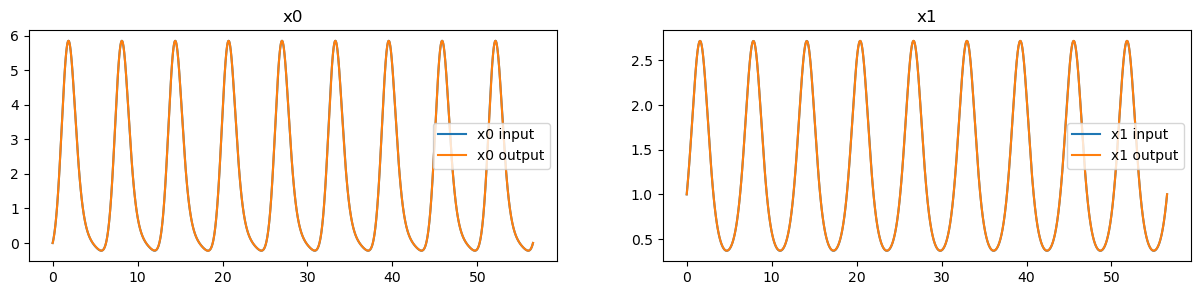

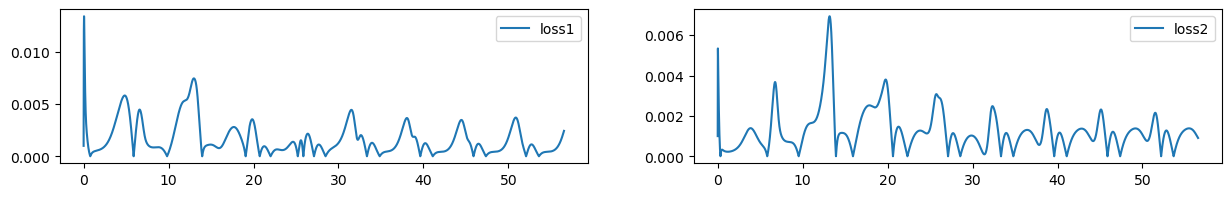

In [17]:
x = np.array(dnn.history_x)
loss = np.array(dnn.history_loss)

fig, ax = plt.subplots(ncols=2, figsize=(15, 3), sharex=True, sharey=False)
ax[0].plot(time, x_input[:,0,:], label=f"x0 input")
ax[0].plot(time, x[:,0,:], label=f"x0 output")
ax[0].set_title('x0')
ax[0].legend()
# ax[0].set_ylim([-6, 6])

ax[1].plot(time, x_input[:,1,:], label=f"x1 input")
ax[1].plot(time, x[:,1,:], label=f"x1 output")
ax[1].set_title('x1')
ax[1].legend()
# ax[1].set_ylim([-6, 3.3])
plt.show()


fig, ax = plt.subplots(ncols=2, figsize=(15, 2), sharex=True, sharey=False)
ax[0].plot(time[:-1], loss[:,0,:], label=f"loss1")
ax[0].legend()
ax[1].plot(time[:-1], loss[:,1,:], label=f"loss2")
ax[1].legend()
plt.show()

